In [1]:
# import required libraries
import torch
from PIL import Image, ImageDraw
import os
import matplotlib.pyplot as plt
import cv2 as cv
import time
import numpy as np 
import torchvision.models as models
from PIL import Image
import torch.nn as nn

In [2]:
def setDevice():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Using {device}")
    return device

In [3]:
def loadYoloModel():
    model = torch.hub.load("ultralytics/yolov5", "yolov5s", pretrained=True)
    return model

In [4]:
def detectSingleImage(imagePath, device, model):
    start = time.time()

    image = Image.open(imagePath).convert('RGB')
    with torch.no_grad():
        result = model(image)
        result.print()
        #print(result.xyxy)
        #print("Names")
        #print(result.pandas().xyxy[0]["name"])
        resultNames = result.pandas().xyxy[0]["name"]
        predictions = result.xyxy[0]

        for i in range(len(predictions)):
            prediction = predictions[i].tolist()
            # print(prediction)
            #print(f"prediction {i}, {resultNames[i]}")
            #print(prediction)
            
            
            if resultNames[i] == "person":
                indexOfClosest = None
                distance = image.size[0]
                for j in range(len(predictions)):
                    prediction2 = predictions[j].tolist()

                    if resultNames[j] == "person":
                        continue
                    else:
                        #print("prediction for non human object")
                        #print(prediction2)

                        # pil image pixel value changing
                        temp = np.array(image)

                        # debug (draw one pixel green)
                        #print("coordinates")
                        #print(round(prediction2[0]))
                        #print(round(prediction2[1]))
                        temp[round(prediction2[1])][round(prediction2[0])]   = [0, 255, 0]
                        image = Image.fromarray(temp)
                        # debug

                        personCenters = (
                            (prediction[2] + prediction[0]) // 2, # (xmax + xmin) / 2  -> x but column value
                            (prediction[3] + prediction[1]) // 2  # (ymax + ymin) / 2  -> y but row value
                        )

                        objCenters = (
                            (prediction2[2] + prediction2[0]) // 2, # (xmax + xmin) / 2  -> x but column value
                            (prediction2[3] + prediction2[1]) // 2  # (ymax + ymin) / 2  -> y but row value
                        )
                        ImageDraw.Draw(image).line((personCenters[0],personCenters[1], objCenters[0], objCenters[1] ), fill="red", width=3)

                        radius = 4
                        ImageDraw.Draw(image).ellipse((personCenters[0]-radius,personCenters[1]-radius,personCenters[0]+radius, personCenters[1]+radius), fill="red", outline="red")
                        ImageDraw.Draw(image).ellipse((objCenters[0]-radius,objCenters[1]-radius,objCenters[0]+radius, objCenters[1]+radius), fill="red", outline="red")


            x_min = round(prediction[0])
            y_min = round(prediction[1])
            x_max = round(prediction[2])
            y_max = round(prediction[3])
            cfdnc = prediction[4]
            if cfdnc < 0.4 and resultNames[i] != "person":
                continue
            color = None
            if resultNames[i] == "person":
                color = "blue"
            else:
                color = "green"  
            ImageDraw.Draw(image).rectangle([x_min,y_min,x_max,y_max], outline =color, width=3)
    
    print(f"Took {time.time()-start} seconds.")
    return image

In [5]:
# set device
device = setDevice()

Using cpu


In [6]:
# loading pretrained model
yoloModel = loadYoloModel()
yoloModel

Using cache found in C:\Users\Burak/.cache\torch\hub\ultralytics_yolov5_master


requirements: seaborn>=0.11.0 not found and is required by YOLOv5, attempting auto-update...


Fusing layers... 


requirements: Command 'pip install 'seaborn>=0.11.0'' returned non-zero exit status 1.
requirements: 1 package updated per C:\Users\Burak\.cache\torch\hub\ultralytics_yolov5_master\requirements.txt
requirements:  Restart runtime or rerun command for updates to take effect



Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 
YOLOv5  2021-6-7 torch 1.8.1+cpu CPU



AutoShape(
  (model): Model(
    (model): Sequential(
      (0): Focus(
        (conv): Conv(
          (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
    

image 1/1: 640x640 5 persons, 1 frisbee, 1 sports ball
Speed: 12.0ms pre-process, 638.0ms inference, 4.0ms NMS per image at shape (1, 3, 640, 640)
Took 0.7810013294219971 seconds.


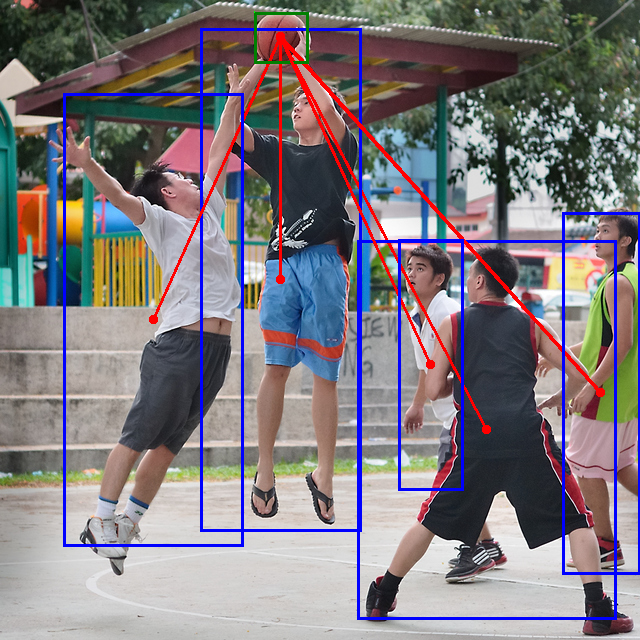

In [7]:
resultImage = detectSingleImage("./HICO_train2015_00000178.jpg", device, yoloModel)
resultImage

In [22]:
import json

f1 = open('./annotations/train_data_with_obj_id.json',)
f2 = open('./annotations/verb_dict.json',)
verbFile = open('./annotations/hico_list_vb.txt',"r")
hoiFile = open('./annotations/hico_list_hoi.txt', "r")

verbLines = verbFile.read().split("\n")
hoiLines = hoiFile.read().split("\n")




data = json.load(f1)
verb_data = json.load(f2)


dataNameArr = data["name"]
actionNoArr = data["action_no"]
obj_listArr = data["obj_list"]
obj_idArr = data["obj_id"]
verb_arr = list(verb_data.values())


for i in dataNameArr:
    actionIndex = actionNoArr[i]
    
    targetVector = np.zeros(117)
            
    
    for j in actionIndex:
            #print(hoiLines[j-1].strip().split(" "), "*****************")
            tempVerb = hoiLines[j-1].strip(" ").split(" ")[-1]
            
            
            tempIndex = verb_arr.index(tempVerb)
            
            result = verbLines[tempIndex]
            
            targetVector[tempIndex] = 1
            
            print([dataNameArr[i]], obj_listArr[i], [tempVerb])
        
    
print(obj_idArr["0"])



  
f1.close()
f2.close()
verbFile.close()
hoiFile.close()

['HICO_train2015_00000001.jpg'] ['motorcycle'] ['race']
['HICO_train2015_00000001.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00000001.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00000001.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00000002.jpg'] ['banana'] ['no_interaction']
['HICO_train2015_00000003.jpg'] ['bus'] ['no_interaction']
['HICO_train2015_00000004.jpg'] ['bottle'] ['drink_with']
['HICO_train2015_00000004.jpg'] ['bottle'] ['hold']
['HICO_train2015_00000005.jpg'] ['bed'] ['sit_on']
['HICO_train2015_00000006.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00000006.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00000007.jpg'] ['pizza'] ['no_interaction']
['HICO_train2015_00000008.jpg'] ['toothbrush'] ['brush_with']
['HICO_train2015_00000008.jpg'] ['toothbrush'] ['hold']
['HICO_train2015_00000009.jpg'] ['truck'] ['load']
['HICO_train2015_00000010.jpg'] ['horse'] ['hold']
['HICO_train2015_00000010.jpg'] ['horse'] ['ride']
['HICO_train2015_00000010.jpg'] ['horse']

['HICO_train2015_00000230.jpg'] ['sheep'] ['no_interaction']
['HICO_train2015_00000231.jpg'] ['boat'] ['repair']
['HICO_train2015_00000231.jpg'] ['boat'] ['ride']
['HICO_train2015_00000231.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00000232.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00000232.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00000232.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00000232.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00000233.jpg'] ['donut'] ['eat']
['HICO_train2015_00000233.jpg'] ['donut'] ['hold']
['HICO_train2015_00000234.jpg'] ['airplane'] ['fly']
['HICO_train2015_00000234.jpg'] ['airplane'] ['ride']
['HICO_train2015_00000234.jpg'] ['airplane'] ['sit_on']
['HICO_train2015_00000235.jpg'] ['kite'] ['fly']
['HICO_train2015_00000235.jpg'] ['kite'] ['hold']
['HICO_train2015_00000235.jpg'] ['kite'] ['pull']
['HICO_train2015_00000236.jpg'] ['person'] ['hold']
['HICO_train2015_00000237.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00000237.jpg'] ['skateboard']

['HICO_train2015_00000487.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00000487.jpg'] ['skis'] ['wear']
['HICO_train2015_00000488.jpg'] ['frisbee'] ['throw']
['HICO_train2015_00000489.jpg'] ['elephant'] ['walk']
['HICO_train2015_00000490.jpg'] ['fire_hydrant'] ['no_interaction']
['HICO_train2015_00000491.jpg'] ['carrot'] ['hold']
['HICO_train2015_00000492.jpg'] ['horse'] ['ride']
['HICO_train2015_00000492.jpg'] ['horse'] ['straddle']
['HICO_train2015_00000493.jpg'] ['kite'] ['carry']
['HICO_train2015_00000493.jpg'] ['kite'] ['hold']
['HICO_train2015_00000493.jpg'] ['kite'] ['inspect']
['HICO_train2015_00000494.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00000494.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00000494.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00000495.jpg'] ['backpack'] ['wear']
['HICO_train2015_00000496.jpg'] ['cake'] ['cut']
['HICO_train2015_00000497.jpg'] ['bus'] ['drive']
['HICO_train2015_00000497.jpg'] ['bus'] ['ride']
['HICO_train2015_00000497.jpg'] ['bu

['HICO_train2015_00000707.jpg'] ['person'] ['no_interaction']
['HICO_train2015_00000708.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00000709.jpg'] ['chair'] ['hold']
['HICO_train2015_00000709.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00000710.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00000710.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00000711.jpg'] ['kite'] ['fly']
['HICO_train2015_00000711.jpg'] ['kite'] ['pull']
['HICO_train2015_00000712.jpg'] ['boat'] ['ride']
['HICO_train2015_00000712.jpg'] ['boat'] ['row']
['HICO_train2015_00000712.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00000713.jpg'] ['couch'] ['lie_on']
['HICO_train2015_00000714.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00000715.jpg'] ['person'] ['no_interaction']
['HICO_train2015_00000716.jpg'] ['baseball_glove'] ['hold']
['HICO_train2015_00000716.jpg'] ['baseball_glove'] ['wear']
['HICO_train2015_00000717.jpg'] ['horse'] ['hold']
['HICO_train2015_00000717.jpg'] ['horse'] ['ride']
['HICO_train2015_0000

['HICO_train2015_00001027.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00001027.jpg'] ['motorcycle'] ['race']
['HICO_train2015_00001027.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00001027.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00001027.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00001027.jpg'] ['motorcycle'] ['turn']
['HICO_train2015_00001028.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00001028.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00001028.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00001028.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00001029.jpg'] ['boat'] ['ride']
['HICO_train2015_00001029.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00001030.jpg'] ['person'] ['hold']
['HICO_train2015_00001030.jpg'] ['person'] ['hug']
['HICO_train2015_00001031.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00001031.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00001032.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00001033.jpg'] ['frisbee'] ['catch']
['H

['HICO_train2015_00001221.jpg'] ['clock'] ['hold']
['HICO_train2015_00001222.jpg'] ['backpack'] ['carry']
['HICO_train2015_00001222.jpg'] ['backpack'] ['wear']
['HICO_train2015_00001223.jpg'] ['handbag'] ['hold']
['HICO_train2015_00001224.jpg'] ['sheep'] ['carry']
['HICO_train2015_00001224.jpg'] ['sheep'] ['hold']
['HICO_train2015_00001224.jpg'] ['sheep'] ['hug']
['HICO_train2015_00001225.jpg'] ['scissors'] ['cut_with']
['HICO_train2015_00001225.jpg'] ['scissors'] ['hold']
['HICO_train2015_00001225.jpg'] ['scissors'] ['open']
['HICO_train2015_00001226.jpg'] ['toothbrush'] ['brush_with']
['HICO_train2015_00001226.jpg'] ['toothbrush'] ['hold']
['HICO_train2015_00001227.jpg'] ['donut'] ['make']
['HICO_train2015_00001228.jpg'] ['bed'] ['lie_on']
['HICO_train2015_00001229.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00001229.jpg'] ['baseball_bat'] ['swing']
['HICO_train2015_00001229.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00001230.jpg'] ['kite'] ['pull']
['HICO_train2015_00001

['HICO_train2015_00001473.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00001474.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00001474.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00001474.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00001475.jpg'] ['frisbee'] ['hold']
['HICO_train2015_00001476.jpg'] ['chair'] ['hold']
['HICO_train2015_00001477.jpg'] ['cup'] ['hold']
['HICO_train2015_00001477.jpg'] ['cup'] ['inspect']
['HICO_train2015_00001478.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00001479.jpg'] ['frisbee'] ['hold']
['HICO_train2015_00001479.jpg'] ['frisbee'] ['spin']
['HICO_train2015_00001480.jpg'] ['boat'] ['ride']
['HICO_train2015_00001480.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00001481.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00001481.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00001481.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00001482.jpg'] ['surfboard'] ['carry']
['HICO_train2015_00001482.jpg'] ['surfboard'] ['hold']
['HICO_train2015_00001483.jpg']

['HICO_train2015_00001738.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00001738.jpg'] ['skis'] ['wear']
['HICO_train2015_00001739.jpg'] ['cake'] ['cut']
['HICO_train2015_00001740.jpg'] ['horse'] ['run']
['HICO_train2015_00001741.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00001741.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00001741.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00001742.jpg'] ['bicycle'] ['no_interaction']
['HICO_train2015_00001743.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00001743.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00001744.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00001745.jpg'] ['horse'] ['ride']
['HICO_train2015_00001745.jpg'] ['horse'] ['run']
['HICO_train2015_00001745.jpg'] ['horse'] ['straddle']
['HICO_train2015_00001746.jpg'] ['kite'] ['assemble']
['HICO_train2015_00001746.jpg'] ['kite'] ['fly']
['HICO_train2015_00001746.jpg'] ['kite'] ['hold']
['HICO_train2015_00001746.jpg'] ['kite'] ['inspect']
['HICO_train2015_00001746.jpg'] ['kite

['HICO_train2015_00001944.jpg'] ['horse'] ['ride']
['HICO_train2015_00001945.jpg'] ['laptop'] ['read']
['HICO_train2015_00001946.jpg'] ['horse'] ['ride']
['HICO_train2015_00001947.jpg'] ['boat'] ['no_interaction']
['HICO_train2015_00001948.jpg'] ['skis'] ['carry']
['HICO_train2015_00001948.jpg'] ['skis'] ['hold']
['HICO_train2015_00001948.jpg'] ['skis'] ['pick_up']
['HICO_train2015_00001949.jpg'] ['bus'] ['drive']
['HICO_train2015_00001949.jpg'] ['bus'] ['exit']
['HICO_train2015_00001949.jpg'] ['bus'] ['ride']
['HICO_train2015_00001949.jpg'] ['bus'] ['sit_on']
['HICO_train2015_00001950.jpg'] ['carrot'] ['hold']
['HICO_train2015_00001951.jpg'] ['bottle'] ['drink_with']
['HICO_train2015_00001951.jpg'] ['bottle'] ['hold']
['HICO_train2015_00001952.jpg'] ['horse'] ['ride']
['HICO_train2015_00001952.jpg'] ['horse'] ['straddle']
['HICO_train2015_00001953.jpg'] ['wine_glass'] ['no_interaction']
['HICO_train2015_00001954.jpg'] ['parking_meter'] ['no_interaction']
['HICO_train2015_00001955.jpg'

['HICO_train2015_00002210.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00002211.jpg'] ['toilet'] ['sit_on']
['HICO_train2015_00002212.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00002213.jpg'] ['skis'] ['ride']
['HICO_train2015_00002213.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00002213.jpg'] ['skis'] ['wear']
['HICO_train2015_00002214.jpg'] ['keyboard'] ['carry']
['HICO_train2015_00002214.jpg'] ['keyboard'] ['hold']
['HICO_train2015_00002215.jpg'] ['train'] ['no_interaction']
['HICO_train2015_00002216.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00002216.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00002216.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00002217.jpg'] ['airplane'] ['fly']
['HICO_train2015_00002218.jpg'] ['cake'] ['blow']
['HICO_train2015_00002219.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00002219.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00002220.jpg'] ['kite'] ['carry']
['HICO_train2015_00002220.jpg'] ['kite'] ['inspect']
['HICO_train2015_0000

['HICO_train2015_00002399.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00002399.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00002399.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00002400.jpg'] ['sports_ball'] ['carry']
['HICO_train2015_00002400.jpg'] ['sports_ball'] ['hold']
['HICO_train2015_00002401.jpg'] ['surfboard'] ['carry']
['HICO_train2015_00002401.jpg'] ['surfboard'] ['hold']
['HICO_train2015_00002402.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00002403.jpg'] ['person'] ['no_interaction']
['HICO_train2015_00002404.jpg'] ['cake'] ['cut']
['HICO_train2015_00002405.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00002406.jpg'] ['bottle'] ['hold']
['HICO_train2015_00002407.jpg'] ['motorcycle'] ['no_interaction']
['HICO_train2015_00002408.jpg'] ['skateboard'] ['carry']
['HICO_train2015_00002408.jpg'] ['skateboard'] ['hold']
['HICO_train2015_00002408.jpg'] ['skateboard'] ['pick_up']
['HICO_train2015_00002409.jpg'] ['bicycle'] ['jump']
['HICO_train2015_00002409.jpg'] ['bicycle'] ['rid

['HICO_train2015_00002668.jpg'] ['book'] ['hold']
['HICO_train2015_00002668.jpg'] ['book'] ['open']
['HICO_train2015_00002668.jpg'] ['book'] ['read']
['HICO_train2015_00002669.jpg'] ['kite'] ['fly']
['HICO_train2015_00002669.jpg'] ['kite'] ['pull']
['HICO_train2015_00002670.jpg'] ['car'] ['drive']
['HICO_train2015_00002671.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00002671.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00002671.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00002671.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00002672.jpg'] ['banana'] ['hold']
['HICO_train2015_00002673.jpg'] ['car'] ['no_interaction']
['HICO_train2015_00002674.jpg'] ['laptop'] ['hold']
['HICO_train2015_00002675.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00002675.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00002675.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00002676.jpg'] ['chair', 'keyboard'] ['sit_on']
['HICO_train2015_00002676.jpg'] ['chair', 'keyboard'] ['no_interaction']
['HIC

['HICO_train2015_00002961.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00002961.jpg'] ['umbrella'] ['open']
['HICO_train2015_00002962.jpg'] ['tennis_racket'] ['carry']
['HICO_train2015_00002962.jpg'] ['tennis_racket'] ['hold']
['HICO_train2015_00002962.jpg'] ['tennis_racket'] ['swing']
['HICO_train2015_00002963.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00002963.jpg'] ['skateboard'] ['hold']
['HICO_train2015_00002963.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00002963.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00002964.jpg'] ['dog'] ['walk']
['HICO_train2015_00002965.jpg'] ['frisbee'] ['catch']
['HICO_train2015_00002966.jpg'] ['sports_ball'] ['catch']
['HICO_train2015_00002967.jpg'] ['truck'] ['load']
['HICO_train2015_00002968.jpg'] ['kite'] ['fly']
['HICO_train2015_00002968.jpg'] ['kite'] ['pull']
['HICO_train2015_00002969.jpg'] ['snowboard'] ['hold']
['HICO_train2015_00002970.jpg'] ['sports_ball'] ['carry']
['HICO_train2015_00002970.jpg'] ['sports_ball'] ['hold']
['HI

['HICO_train2015_00003167.jpg'] ['backpack'] ['carry']
['HICO_train2015_00003167.jpg'] ['backpack'] ['wear']
['HICO_train2015_00003168.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00003169.jpg'] ['car'] ['no_interaction']
['HICO_train2015_00003170.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00003171.jpg'] ['broccoli'] ['eat']
['HICO_train2015_00003171.jpg'] ['broccoli'] ['hold']
['HICO_train2015_00003172.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00003173.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00003173.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00003174.jpg'] ['laptop'] ['hold']
['HICO_train2015_00003175.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00003175.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00003175.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00003176.jpg'] ['train'] ['ride']
['HICO_train2015_00003177.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00003177.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00003178.jpg'] ['cake'] ['carry']
['HICO_train

['HICO_train2015_00003406.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00003406.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00003407.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00003407.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00003407.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00003407.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00003408.jpg'] ['truck'] ['drive']
['HICO_train2015_00003408.jpg'] ['truck'] ['ride']
['HICO_train2015_00003409.jpg'] ['skateboard'] ['grind']
['HICO_train2015_00003409.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00003409.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00003409.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00003410.jpg'] ['boat'] ['ride']
['HICO_train2015_00003410.jpg'] ['boat'] ['row']
['HICO_train2015_00003410.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00003410.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00003411.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00003412.jpg'] ['bicycle'] ['hold']
['HICO_train2015_000

['HICO_train2015_00003662.jpg'] ['skis'] ['wear']
['HICO_train2015_00003663.jpg'] ['giraffe'] ['watch']
['HICO_train2015_00003664.jpg'] ['cake'] ['cut']
['HICO_train2015_00003665.jpg'] ['spoon'] ['hold']
['HICO_train2015_00003666.jpg'] ['clock'] ['no_interaction']
['HICO_train2015_00003667.jpg'] ['airplane'] ['fly']
['HICO_train2015_00003667.jpg'] ['airplane'] ['ride']
['HICO_train2015_00003667.jpg'] ['airplane'] ['sit_on']
['HICO_train2015_00003668.jpg'] ['spoon'] ['hold']
['HICO_train2015_00003669.jpg'] ['boat'] ['ride']
['HICO_train2015_00003669.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00003670.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00003670.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00003670.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00003670.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00003671.jpg'] ['kite'] ['fly']
['HICO_train2015_00003671.jpg'] ['kite'] ['pull']
['HICO_train2015_00003672.jpg'] ['wine_glass'] ['hold']
['HICO_train2015_00003673.jpg'] ['

['HICO_train2015_00003914.jpg'] ['backpack'] ['carry']
['HICO_train2015_00003914.jpg'] ['backpack'] ['wear']
['HICO_train2015_00003915.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00003915.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00003916.jpg'] ['banana'] ['hold']
['HICO_train2015_00003917.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00003918.jpg'] ['pizza'] ['carry']
['HICO_train2015_00003918.jpg'] ['pizza'] ['hold']
['HICO_train2015_00003919.jpg'] ['skateboard'] ['grind']
['HICO_train2015_00003919.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00003919.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00003920.jpg'] ['cell_phone'] ['carry']
['HICO_train2015_00003920.jpg'] ['cell_phone'] ['hold']
['HICO_train2015_00003920.jpg'] ['cell_phone'] ['read']
['HICO_train2015_00003920.jpg'] ['cell_phone'] ['text_on']
['HICO_train2015_00003921.jpg'] ['dog'] ['pet']
['HICO_train2015_00003922.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00003922.jpg'] ['umbrella'] ['hold']
['HICO

['HICO_train2015_00004105.jpg'] ['baseball_glove'] ['wear']
['HICO_train2015_00004106.jpg'] ['suitcase'] ['carry']
['HICO_train2015_00004107.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00004107.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00004108.jpg'] ['cell_phone'] ['hold']
['HICO_train2015_00004108.jpg'] ['cell_phone'] ['talk_on']
['HICO_train2015_00004109.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00004109.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00004110.jpg'] ['car'] ['no_interaction']
['HICO_train2015_00004111.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00004112.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00004113.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00004113.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00004113.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00004114.jpg'] ['hot_dog'] ['cook']
['HICO_train2015_00004115.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00004116.jpg'] ['bottle'] ['carry']
['HICO_train2015_00004116.jpg'] ['bottle'] ['h

['HICO_train2015_00004322.jpg'] ['person'] ['hold']
['HICO_train2015_00004322.jpg'] ['person'] ['hug']
['HICO_train2015_00004323.jpg'] ['person'] ['greet']
['HICO_train2015_00004324.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00004324.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00004324.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00004325.jpg'] ['pizza'] ['carry']
['HICO_train2015_00004325.jpg'] ['pizza'] ['eat']
['HICO_train2015_00004325.jpg'] ['pizza'] ['hold']
['HICO_train2015_00004326.jpg'] ['backpack'] ['carry']
['HICO_train2015_00004326.jpg'] ['backpack'] ['wear']
['HICO_train2015_00004327.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00004327.jpg'] ['baseball_bat'] ['swing']
['HICO_train2015_00004327.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00004328.jpg'] ['train'] ['ride']
['HICO_train2015_00004328.jpg'] ['train'] ['sit_on']
['HICO_train2015_00004329.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00004329.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_000043

['HICO_train2015_00004611.jpg'] ['sports_ball'] ['hit']
['HICO_train2015_00004611.jpg'] ['sports_ball'] ['throw']
['HICO_train2015_00004612.jpg'] ['backpack'] ['carry']
['HICO_train2015_00004612.jpg'] ['backpack'] ['hold']
['HICO_train2015_00004612.jpg'] ['backpack'] ['inspect']
['HICO_train2015_00004612.jpg'] ['backpack'] ['open']
['HICO_train2015_00004612.jpg'] ['backpack'] ['wear']
['HICO_train2015_00004613.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00004613.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00004614.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00004615.jpg'] ['horse'] ['ride']
['HICO_train2015_00004615.jpg'] ['horse'] ['straddle']
['HICO_train2015_00004616.jpg'] ['airplane'] ['no_interaction']
['HICO_train2015_00004617.jpg'] ['cell_phone'] ['hold']
['HICO_train2015_00004617.jpg'] ['cell_phone'] ['talk_on']
['HICO_train2015_00004618.jpg'] ['bus'] ['ride']
['HICO_train2015_00004618.jpg'] ['bus'] ['sit_on']
['HICO_train2015_00004619.jpg'] ['person'] ['no_inte

['HICO_train2015_00004823.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00004824.jpg'] ['clock'] ['no_interaction']
['HICO_train2015_00004825.jpg'] ['toilet'] ['no_interaction']
['HICO_train2015_00004826.jpg'] ['banana'] ['carry']
['HICO_train2015_00004826.jpg'] ['banana'] ['inspect']
['HICO_train2015_00004827.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00004827.jpg'] ['baseball_bat'] ['swing']
['HICO_train2015_00004827.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00004828.jpg'] ['stop_sign'] ['hold']
['HICO_train2015_00004828.jpg'] ['stop_sign'] ['stand_under']
['HICO_train2015_00004829.jpg'] ['truck'] ['drive']
['HICO_train2015_00004829.jpg'] ['truck'] ['sit_on']
['HICO_train2015_00004830.jpg'] ['kite'] ['fly']
['HICO_train2015_00004830.jpg'] ['kite'] ['pull']
['HICO_train2015_00004831.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00004831.jpg'] ['motorcycle'] ['jump']
['HICO_train2015_00004831.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00004832.jpg'] ['baseball_bat'] ['

['HICO_train2015_00005020.jpg'] ['horse'] ['run']
['HICO_train2015_00005020.jpg'] ['horse'] ['straddle']
['HICO_train2015_00005021.jpg'] ['potted_plant'] ['hose']
['HICO_train2015_00005022.jpg'] ['bus'] ['ride']
['HICO_train2015_00005023.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00005024.jpg'] ['couch'] ['lie_on']
['HICO_train2015_00005025.jpg'] ['wine_glass'] ['fill']
['HICO_train2015_00005025.jpg'] ['wine_glass'] ['hold']
['HICO_train2015_00005026.jpg'] ['wine_glass'] ['no_interaction']
['HICO_train2015_00005027.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00005027.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00005028.jpg'] ['bottle'] ['hold']
['HICO_train2015_00005029.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00005029.jpg'] ['skis'] ['wear']
['HICO_train2015_00005030.jpg'] ['toothbrush'] ['brush_with']
['HICO_train2015_00005030.jpg'] ['toothbrush'] ['hold']
['HICO_train2015_00005031.jpg'] ['train'] ['no_interaction']
['HICO_train2015_00005032.jpg'] ['motorcycle'] ['ride']
[

['HICO_train2015_00005238.jpg'] ['bus'] ['ride']
['HICO_train2015_00005238.jpg'] ['bus'] ['sit_on']
['HICO_train2015_00005239.jpg'] ['backpack'] ['carry']
['HICO_train2015_00005239.jpg'] ['backpack'] ['wear']
['HICO_train2015_00005240.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00005240.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00005240.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00005240.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00005241.jpg'] ['airplane'] ['fly']
['HICO_train2015_00005242.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00005242.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00005242.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00005243.jpg'] ['knife'] ['hold']
['HICO_train2015_00005243.jpg'] ['knife'] ['wield']
['HICO_train2015_00005244.jpg'] ['frisbee'] ['catch']
['HICO_train2015_00005245.jpg'] ['cup'] ['hold']
['HICO_train2015_00005245.jpg'] ['cup'] ['fill']
['HICO_train2015_00005246.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00005246.

['HICO_train2015_00005492.jpg'] ['vase'] ['no_interaction']
['HICO_train2015_00005493.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00005493.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00005493.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00005494.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00005494.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00005494.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00005495.jpg'] ['sheep'] ['hold']
['HICO_train2015_00005496.jpg'] ['laptop'] ['read']
['HICO_train2015_00005497.jpg'] ['tennis_racket'] ['carry']
['HICO_train2015_00005497.jpg'] ['tennis_racket'] ['hold']
['HICO_train2015_00005497.jpg'] ['tennis_racket'] ['swing']
['HICO_train2015_00005498.jpg'] ['traffic_light'] ['no_interaction']
['HICO_train2015_00005499.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00005500.jpg'] ['car'] ['drive']
['HICO_train2015_00005500.jpg'] ['car'] ['ride']
['HICO_train2015_00005501.jpg'] ['person'] ['no_interaction']
['HICO_train2015_0000550

['HICO_train2015_00005687.jpg'] ['snowboard'] ['wear']
['HICO_train2015_00005688.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00005688.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00005689.jpg'] ['boat'] ['ride']
['HICO_train2015_00005689.jpg'] ['boat'] ['row']
['HICO_train2015_00005689.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00005689.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00005690.jpg'] ['laptop'] ['read']
['HICO_train2015_00005690.jpg'] ['laptop'] ['type_on']
['HICO_train2015_00005691.jpg'] ['bicycle'] ['no_interaction']
['HICO_train2015_00005692.jpg'] ['truck'] ['load']
['HICO_train2015_00005693.jpg'] ['knife'] ['hold']
['HICO_train2015_00005693.jpg'] ['knife'] ['wield']
['HICO_train2015_00005694.jpg'] ['bottle'] ['carry']
['HICO_train2015_00005694.jpg'] ['bottle'] ['hold']
['HICO_train2015_00005695.jpg'] ['cup'] ['carry']
['HICO_train2015_00005695.jpg'] ['cup'] ['drink_with']
['HICO_train2015_00005695.jpg'] ['cup'] ['hold']
['HICO_train2015_00005695.jpg'] ['cup

['HICO_train2015_00005917.jpg'] ['surfboard'] ['no_interaction']
['HICO_train2015_00005918.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00005918.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00005919.jpg'] ['giraffe'] ['feed']
['HICO_train2015_00005919.jpg'] ['giraffe'] ['watch']
['HICO_train2015_00005920.jpg'] ['motorcycle'] ['race']
['HICO_train2015_00005920.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00005920.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00005920.jpg'] ['motorcycle'] ['turn']
['HICO_train2015_00005921.jpg'] ['tie'] ['hold']
['HICO_train2015_00005922.jpg'] ['giraffe'] ['feed']
['HICO_train2015_00005922.jpg'] ['giraffe'] ['watch']
['HICO_train2015_00005923.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00005923.jpg'] ['skis'] ['wear']
['HICO_train2015_00005924.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00005924.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00005925.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00005925.jpg'] ['bicycle'] ['ride']
['HICO_tr

['HICO_train2015_00006206.jpg'] ['motorcycle'] ['race']
['HICO_train2015_00006206.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00006206.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00006207.jpg'] ['elephant'] ['hop_on']
['HICO_train2015_00006207.jpg'] ['elephant'] ['ride']
['HICO_train2015_00006207.jpg'] ['elephant'] ['watch']
['HICO_train2015_00006208.jpg'] ['car'] ['wash']
['HICO_train2015_00006209.jpg'] ['train'] ['ride']
['HICO_train2015_00006210.jpg'] ['wine_glass'] ['no_interaction']
['HICO_train2015_00006211.jpg'] ['pizza'] ['hold']
['HICO_train2015_00006212.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00006212.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00006213.jpg'] ['hot_dog'] ['hold']
['HICO_train2015_00006214.jpg'] ['dog'] ['hold']
['HICO_train2015_00006214.jpg'] ['dog'] ['hug']
['HICO_train2015_00006214.jpg'] ['dog'] ['scratch']
['HICO_train2015_00006215.jpg'] ['frisbee'] ['catch']
['HICO_train2015_00006216.jpg'] ['backpack'] ['carry']
['HICO_train2015_0000

['HICO_train2015_00006468.jpg'] ['car'] ['drive']
['HICO_train2015_00006468.jpg'] ['car'] ['ride']
['HICO_train2015_00006469.jpg'] ['pizza'] ['eat']
['HICO_train2015_00006469.jpg'] ['pizza'] ['hold']
['HICO_train2015_00006470.jpg'] ['elephant'] ['hose']
['HICO_train2015_00006470.jpg'] ['elephant'] ['wash']
['HICO_train2015_00006470.jpg'] ['elephant'] ['watch']
['HICO_train2015_00006471.jpg'] ['snowboard'] ['grind']
['HICO_train2015_00006471.jpg'] ['snowboard'] ['ride']
['HICO_train2015_00006471.jpg'] ['snowboard'] ['stand_on']
['HICO_train2015_00006471.jpg'] ['snowboard'] ['wear']
['HICO_train2015_00006472.jpg'] ['snowboard'] ['grind']
['HICO_train2015_00006472.jpg'] ['snowboard'] ['ride']
['HICO_train2015_00006472.jpg'] ['snowboard'] ['stand_on']
['HICO_train2015_00006472.jpg'] ['snowboard'] ['wear']
['HICO_train2015_00006473.jpg'] ['handbag'] ['hold']
['HICO_train2015_00006474.jpg'] ['tie'] ['wear']
['HICO_train2015_00006475.jpg'] ['motorcycle'] ['race']
['HICO_train2015_00006475.jpg

['HICO_train2015_00006649.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00006649.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00006650.jpg'] ['cake'] ['blow']
['HICO_train2015_00006651.jpg'] ['sandwich'] ['eat']
['HICO_train2015_00006651.jpg'] ['sandwich'] ['hold']
['HICO_train2015_00006652.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00006653.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00006654.jpg'] ['bus'] ['ride']
['HICO_train2015_00006655.jpg'] ['parking_meter'] ['check']
['HICO_train2015_00006655.jpg'] ['parking_meter'] ['pay']
['HICO_train2015_00006656.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00006656.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00006657.jpg'] ['suitcase'] ['pack']
['HICO_train2015_00006658.jpg'] ['cup'] ['carry']
['HICO_train2015_00006658.jpg'] ['cup'] ['drink_with']
['HICO_train2015_00006658.jpg'] ['cup'] ['hold']
['HICO_train2015_00006658.jpg'] ['cup'] ['sip']
['HICO_train2015_00006659.jpg'] ['tie'] ['wear']
['HICO_train2015_00006660.jpg'] ['s

['HICO_train2015_00006877.jpg'] ['banana', 'elephant'] ['feed']
['HICO_train2015_00006878.jpg'] ['horse'] ['ride']
['HICO_train2015_00006878.jpg'] ['horse'] ['straddle']
['HICO_train2015_00006879.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00006879.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00006879.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00006880.jpg'] ['boat'] ['drive']
['HICO_train2015_00006880.jpg'] ['boat'] ['ride']
['HICO_train2015_00006880.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00006881.jpg'] ['dog'] ['walk']
['HICO_train2015_00006882.jpg'] ['bus'] ['ride']
['HICO_train2015_00006883.jpg'] ['backpack'] ['carry']
['HICO_train2015_00006883.jpg'] ['backpack'] ['wear']
['HICO_train2015_00006884.jpg'] ['horse'] ['ride']
['HICO_train2015_00006885.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00006885.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00006885.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00006886.jpg'] ['vase'] ['no_interaction']
['HICO_train2015_00006887.

['HICO_train2015_00007168.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00007169.jpg'] ['sports_ball'] ['kick']
['HICO_train2015_00007170.jpg'] ['elephant'] ['ride']
['HICO_train2015_00007170.jpg'] ['elephant'] ['watch']
['HICO_train2015_00007171.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00007171.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00007171.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00007172.jpg'] ['boat'] ['ride']
['HICO_train2015_00007172.jpg'] ['boat'] ['row']
['HICO_train2015_00007172.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00007173.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00007173.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00007174.jpg'] ['wine_glass'] ['no_interaction']
['HICO_train2015_00007175.jpg'] ['sink'] ['no_interaction']
['HICO_train2015_00007176.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00007176.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00007176.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00007177.jpg'] ['bicycle'] ['h

['HICO_train2015_00007413.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00007413.jpg'] ['bicycle'] ['walk']
['HICO_train2015_00007414.jpg'] ['sports_ball'] ['throw']
['HICO_train2015_00007415.jpg'] ['knife', 'toilet'] ['hold']
['HICO_train2015_00007415.jpg'] ['knife', 'toilet'] ['wield']
['HICO_train2015_00007415.jpg'] ['knife', 'toilet'] ['sit_on']
['HICO_train2015_00007416.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00007416.jpg'] ['baseball_bat'] ['swing']
['HICO_train2015_00007416.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00007417.jpg'] ['boat'] ['ride']
['HICO_train2015_00007417.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00007418.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00007418.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00007419.jpg'] ['skateboard'] ['grind']
['HICO_train2015_00007419.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00007419.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00007419.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_0000742

['HICO_train2015_00007606.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00007607.jpg'] ['snowboard'] ['ride']
['HICO_train2015_00007607.jpg'] ['snowboard'] ['stand_on']
['HICO_train2015_00007607.jpg'] ['snowboard'] ['wear']
['HICO_train2015_00007608.jpg'] ['frisbee'] ['hold']
['HICO_train2015_00007609.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00007609.jpg'] ['baseball_bat'] ['swing']
['HICO_train2015_00007609.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00007610.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00007611.jpg'] ['skateboard'] ['carry']
['HICO_train2015_00007611.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00007611.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00007611.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00007612.jpg'] ['train'] ['board']
['HICO_train2015_00007612.jpg'] ['train'] ['ride']
['HICO_train2015_00007613.jpg'] ['cell_phone'] ['hold']
['HICO_train2015_00007613.jpg'] ['cell_phone'] ['talk_on']
['HICO_train2015_00007614.jpg'] ['umbrella'] ['carry

['HICO_train2015_00007825.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00007825.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00007825.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00007826.jpg'] ['kite'] ['fly']
['HICO_train2015_00007826.jpg'] ['kite'] ['hold']
['HICO_train2015_00007827.jpg'] ['bed'] ['no_interaction']
['HICO_train2015_00007828.jpg'] ['sports_ball', 'tennis_racket'] ['hit']
['HICO_train2015_00007828.jpg'] ['sports_ball', 'tennis_racket'] ['carry']
['HICO_train2015_00007828.jpg'] ['sports_ball', 'tennis_racket'] ['hold']
['HICO_train2015_00007828.jpg'] ['sports_ball', 'tennis_racket'] ['swing']
['HICO_train2015_00007829.jpg'] ['wine_glass'] ['no_interaction']
['HICO_train2015_00007830.jpg'] ['sheep'] ['feed']
['HICO_train2015_00007831.jpg'] ['skateboard'] ['hold']
['HICO_train2015_00007831.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00007831.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00007831.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00007832.jpg'

['HICO_train2015_00008071.jpg'] ['snowboard'] ['no_interaction']
['HICO_train2015_00008072.jpg'] ['fork'] ['no_interaction']
['HICO_train2015_00008073.jpg'] ['tv'] ['watch']
['HICO_train2015_00008074.jpg'] ['bus'] ['drive']
['HICO_train2015_00008074.jpg'] ['bus'] ['ride']
['HICO_train2015_00008074.jpg'] ['bus'] ['sit_on']
['HICO_train2015_00008075.jpg'] ['surfboard'] ['hold']
['HICO_train2015_00008076.jpg'] ['truck'] ['repair']
['HICO_train2015_00008077.jpg'] ['kite'] ['fly']
['HICO_train2015_00008077.jpg'] ['kite'] ['pull']
['HICO_train2015_00008078.jpg'] ['boat'] ['ride']
['HICO_train2015_00008078.jpg'] ['boat'] ['sail']
['HICO_train2015_00008078.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00008078.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00008079.jpg'] ['handbag'] ['carry']
['HICO_train2015_00008080.jpg'] ['backpack'] ['carry']
['HICO_train2015_00008080.jpg'] ['backpack'] ['wear']
['HICO_train2015_00008081.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00008082.jpg'] ['carrot'] ['cu

['HICO_train2015_00008358.jpg'] ['tennis_racket'] ['hold']
['HICO_train2015_00008359.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00008360.jpg'] ['tie'] ['wear']
['HICO_train2015_00008361.jpg'] ['banana'] ['hold']
['HICO_train2015_00008362.jpg'] ['chair'] ['hold']
['HICO_train2015_00008362.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00008363.jpg'] ['teddy_bear'] ['hold']
['HICO_train2015_00008364.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00008364.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00008364.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00008365.jpg'] ['kite'] ['fly']
['HICO_train2015_00008366.jpg'] ['frisbee'] ['hold']
['HICO_train2015_00008366.jpg'] ['frisbee'] ['spin']
['HICO_train2015_00008367.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00008367.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00008368.jpg'] ['horse'] ['ride']
['HICO_train2015_00008368.jpg'] ['horse'] ['straddle']
['HICO_train2015_00008369.jpg'] ['keyboard'] ['hold']
['HICO_train2015_00008370.jpg'] ['couc

['HICO_train2015_00008576.jpg'] ['dog'] ['kiss']
['HICO_train2015_00008577.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00008577.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00008578.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00008579.jpg'] ['backpack'] ['carry']
['HICO_train2015_00008579.jpg'] ['backpack'] ['wear']
['HICO_train2015_00008580.jpg'] ['car'] ['no_interaction']
['HICO_train2015_00008581.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00008581.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00008582.jpg'] ['pizza'] ['eat']
['HICO_train2015_00008582.jpg'] ['pizza'] ['hold']
['HICO_train2015_00008583.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00008583.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00008583.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00008584.jpg'] ['sheep'] ['no_interaction']
['HICO_train2015_00008585.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00008585.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00008586.jpg'] ['cell_phone'] ['hold

['HICO_train2015_00008813.jpg'] ['bus'] ['sit_on']
['HICO_train2015_00008814.jpg'] ['sheep'] ['no_interaction']
['HICO_train2015_00008815.jpg'] ['laptop'] ['hold']
['HICO_train2015_00008815.jpg'] ['laptop'] ['open']
['HICO_train2015_00008815.jpg'] ['laptop'] ['read']
['HICO_train2015_00008816.jpg'] ['motorcycle'] ['race']
['HICO_train2015_00008816.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00008816.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00008816.jpg'] ['motorcycle'] ['turn']
['HICO_train2015_00008817.jpg'] ['kite'] ['fly']
['HICO_train2015_00008817.jpg'] ['kite'] ['pull']
['HICO_train2015_00008818.jpg'] ['sheep'] ['herd']
['HICO_train2015_00008818.jpg'] ['sheep'] ['walk']
['HICO_train2015_00008819.jpg'] ['bus'] ['drive']
['HICO_train2015_00008819.jpg'] ['bus'] ['ride']
['HICO_train2015_00008820.jpg'] ['horse'] ['ride']
['HICO_train2015_00008820.jpg'] ['horse'] ['run']
['HICO_train2015_00008820.jpg'] ['horse'] ['straddle']
['HICO_train2015_00008821.jpg'] ['cell_phone'] ['h

['HICO_train2015_00009030.jpg'] ['book'] ['hold']
['HICO_train2015_00009030.jpg'] ['book'] ['open']
['HICO_train2015_00009030.jpg'] ['book'] ['read']
['HICO_train2015_00009031.jpg'] ['car'] ['hose']
['HICO_train2015_00009031.jpg'] ['car'] ['wash']
['HICO_train2015_00009032.jpg'] ['boat'] ['ride']
['HICO_train2015_00009032.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00009032.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00009033.jpg'] ['knife'] ['hold']
['HICO_train2015_00009033.jpg'] ['knife'] ['wield']
['HICO_train2015_00009034.jpg'] ['skis'] ['ride']
['HICO_train2015_00009034.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00009034.jpg'] ['skis'] ['wear']
['HICO_train2015_00009035.jpg'] ['sports_ball'] ['hold']
['HICO_train2015_00009035.jpg'] ['sports_ball'] ['throw']
['HICO_train2015_00009036.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00009036.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00009037.jpg'] ['horse'] ['pet']
['HICO_train2015_00009038.jpg'] ['keyboard', 'laptop'] ['type_on']
[

['HICO_train2015_00009306.jpg'] ['cell_phone'] ['hold']
['HICO_train2015_00009307.jpg'] ['skis'] ['ride']
['HICO_train2015_00009307.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00009308.jpg'] ['chair'] ['hold']
['HICO_train2015_00009308.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00009309.jpg'] ['dog'] ['walk']
['HICO_train2015_00009310.jpg'] ['sports_ball'] ['throw']
['HICO_train2015_00009311.jpg'] ['spoon'] ['hold']
['HICO_train2015_00009311.jpg'] ['spoon'] ['lick']
['HICO_train2015_00009312.jpg'] ['fire_hydrant'] ['no_interaction']
['HICO_train2015_00009313.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00009314.jpg'] ['motorcycle'] ['no_interaction']
['HICO_train2015_00009315.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00009316.jpg'] ['bottle'] ['hold']
['HICO_train2015_00009317.jpg'] ['elephant'] ['hold']
['HICO_train2015_00009317.jpg'] ['elephant'] ['pet']
['HICO_train2015_00009317.jpg'] ['elephant'] ['watch']
['HICO_train2015_00009318.jpg'] ['dining_table'] ['eat_at']
['HICO_train2

['HICO_train2015_00009550.jpg'] ['bowl'] ['hold']
['HICO_train2015_00009551.jpg'] ['cup'] ['hold']
['HICO_train2015_00009551.jpg'] ['cup'] ['fill']
['HICO_train2015_00009552.jpg'] ['truck'] ['drive']
['HICO_train2015_00009552.jpg'] ['truck'] ['ride']
['HICO_train2015_00009553.jpg'] ['book'] ['hold']
['HICO_train2015_00009553.jpg'] ['book'] ['open']
['HICO_train2015_00009554.jpg'] ['backpack', 'umbrella'] ['carry']
['HICO_train2015_00009554.jpg'] ['backpack', 'umbrella'] ['wear']
['HICO_train2015_00009554.jpg'] ['backpack', 'umbrella'] ['carry']
['HICO_train2015_00009554.jpg'] ['backpack', 'umbrella'] ['hold']
['HICO_train2015_00009555.jpg'] ['surfboard'] ['no_interaction']
['HICO_train2015_00009556.jpg'] ['bus'] ['drive']
['HICO_train2015_00009556.jpg'] ['bus'] ['ride']
['HICO_train2015_00009556.jpg'] ['bus'] ['sit_on']
['HICO_train2015_00009557.jpg'] ['cell_phone'] ['hold']
['HICO_train2015_00009557.jpg'] ['cell_phone'] ['talk_on']
['HICO_train2015_00009558.jpg'] ['truck'] ['ride']
['

['HICO_train2015_00009834.jpg'] ['bed'] ['sit_on']
['HICO_train2015_00009835.jpg'] ['cup'] ['drink_with']
['HICO_train2015_00009835.jpg'] ['cup'] ['hold']
['HICO_train2015_00009836.jpg'] ['backpack'] ['carry']
['HICO_train2015_00009836.jpg'] ['backpack'] ['wear']
['HICO_train2015_00009837.jpg'] ['kite'] ['fly']
['HICO_train2015_00009837.jpg'] ['kite'] ['pull']
['HICO_train2015_00009838.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00009839.jpg'] ['bus'] ['exit']
['HICO_train2015_00009839.jpg'] ['bus'] ['ride']
['HICO_train2015_00009840.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00009840.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00009840.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00009841.jpg'] ['bed'] ['sit_on']
['HICO_train2015_00009842.jpg'] ['remote'] ['hold']
['HICO_train2015_00009843.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00009844.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00009845.jpg'] ['knife'] ['hold']
['HICO_train2015_00009846.jpg'] ['skis'] ['in

['HICO_train2015_00010119.jpg'] ['bus'] ['ride']
['HICO_train2015_00010120.jpg'] ['skateboard'] ['carry']
['HICO_train2015_00010120.jpg'] ['skateboard'] ['hold']
['HICO_train2015_00010120.jpg'] ['skateboard'] ['pick_up']
['HICO_train2015_00010120.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00010121.jpg'] ['elephant'] ['ride']
['HICO_train2015_00010122.jpg'] ['bottle'] ['no_interaction']
['HICO_train2015_00010123.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00010123.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00010124.jpg'] ['cow'] ['no_interaction']
['HICO_train2015_00010125.jpg'] ['sandwich'] ['eat']
['HICO_train2015_00010125.jpg'] ['sandwich'] ['hold']
['HICO_train2015_00010126.jpg'] ['bus'] ['drive']
['HICO_train2015_00010126.jpg'] ['bus'] ['ride']
['HICO_train2015_00010127.jpg'] ['airplane'] ['inspect']
['HICO_train2015_00010128.jpg'] ['surfboard'] ['carry']
['HICO_train2015_00010128.jpg'] ['surfboard'] ['hold']
['HICO_train2015_00010129.jpg'] ['elephant'] ['ride']
['HI

['HICO_train2015_00010356.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00010356.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00010357.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00010358.jpg'] ['bed'] ['lie_on']
['HICO_train2015_00010359.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00010359.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00010360.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00010360.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00010361.jpg'] ['suitcase'] ['no_interaction']
['HICO_train2015_00010362.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00010362.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00010362.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00010362.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00010363.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00010363.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00010364.jpg'] ['elephant'] ['feed']
['HICO_train2015_00010364.jpg'] ['elephant'] ['watch']
['HICO_train2015_00010365.jpg'] ['a

['HICO_train2015_00010624.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00010624.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00010625.jpg'] ['bear'] ['feed']
['HICO_train2015_00010625.jpg'] ['bear'] ['watch']
['HICO_train2015_00010626.jpg'] ['horse'] ['hold']
['HICO_train2015_00010626.jpg'] ['horse'] ['walk']
['HICO_train2015_00010627.jpg'] ['bottle'] ['carry']
['HICO_train2015_00010628.jpg'] ['book'] ['hold']
['HICO_train2015_00010628.jpg'] ['book'] ['open']
['HICO_train2015_00010628.jpg'] ['book'] ['read']
['HICO_train2015_00010629.jpg'] ['traffic_light'] ['no_interaction']
['HICO_train2015_00010630.jpg'] ['wine_glass'] ['no_interaction']
['HICO_train2015_00010631.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00010631.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00010632.jpg'] ['horse'] ['ride']
['HICO_train2015_00010632.jpg'] ['horse'] ['run']
['HICO_train2015_00010632.jpg'] ['horse'] ['straddle']
['HICO_train2015_00010633.jpg'] ['cup'] ['carry']
['HICO_train2015_0001

['HICO_train2015_00010826.jpg'] ['banana'] ['no_interaction']
['HICO_train2015_00010827.jpg'] ['boat'] ['ride']
['HICO_train2015_00010827.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00010828.jpg'] ['backpack'] ['carry']
['HICO_train2015_00010828.jpg'] ['backpack'] ['wear']
['HICO_train2015_00010829.jpg'] ['scissors'] ['cut_with']
['HICO_train2015_00010829.jpg'] ['scissors'] ['hold']
['HICO_train2015_00010829.jpg'] ['scissors'] ['open']
['HICO_train2015_00010830.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00010830.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00010831.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00010831.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00010832.jpg'] ['knife'] ['hold']
['HICO_train2015_00010832.jpg'] ['knife'] ['wield']
['HICO_train2015_00010833.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00010834.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00010835.jpg'] ['sandwich'] ['eat']
['HICO_train2015_00010836.jpg'] ['boat'] ['launch']
['HICO_train2015

['HICO_train2015_00011105.jpg'] ['bed'] ['lie_on']
['HICO_train2015_00011106.jpg'] ['horse'] ['hold']
['HICO_train2015_00011106.jpg'] ['horse'] ['ride']
['HICO_train2015_00011106.jpg'] ['horse'] ['straddle']
['HICO_train2015_00011107.jpg'] ['boat'] ['ride']
['HICO_train2015_00011107.jpg'] ['boat'] ['row']
['HICO_train2015_00011107.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00011108.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00011108.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00011109.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00011110.jpg'] ['car'] ['drive']
['HICO_train2015_00011110.jpg'] ['car'] ['ride']
['HICO_train2015_00011111.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00011112.jpg'] ['person'] ['no_interaction']
['HICO_train2015_00011113.jpg'] ['spoon'] ['hold']
['HICO_train2015_00011113.jpg'] ['spoon'] ['lick']
['HICO_train2015_00011114.jpg'] ['bus'] ['drive']
['HICO_train2015_00011115.jpg'] ['sports_ball'] ['carry']
['HICO_train2015_00011115.jpg'] ['sp

['HICO_train2015_00011304.jpg'] ['backpack'] ['carry']
['HICO_train2015_00011304.jpg'] ['backpack'] ['hold']
['HICO_train2015_00011305.jpg'] ['surfboard'] ['hold']
['HICO_train2015_00011306.jpg'] ['banana'] ['no_interaction']
['HICO_train2015_00011307.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00011307.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00011307.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00011307.jpg'] ['motorcycle'] ['turn']
['HICO_train2015_00011308.jpg'] ['boat'] ['ride']
['HICO_train2015_00011308.jpg'] ['boat'] ['row']
['HICO_train2015_00011308.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00011308.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00011309.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00011310.jpg'] ['cake'] ['hold']
['HICO_train2015_00011311.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00011311.jpg'] ['skis'] ['wear']
['HICO_train2015_00011312.jpg'] ['person'] ['no_interaction']
['HICO_train2015_00011313.jpg'] ['bottle'] ['hold']
['HICO_train2015_00011

['HICO_train2015_00011603.jpg'] ['book'] ['hold']
['HICO_train2015_00011603.jpg'] ['book'] ['read']
['HICO_train2015_00011604.jpg'] ['remote'] ['hold']
['HICO_train2015_00011605.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00011606.jpg'] ['person'] ['hold']
['HICO_train2015_00011607.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00011608.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00011609.jpg'] ['donut'] ['carry']
['HICO_train2015_00011610.jpg'] ['horse'] ['hold']
['HICO_train2015_00011610.jpg'] ['horse'] ['ride']
['HICO_train2015_00011610.jpg'] ['horse'] ['straddle']
['HICO_train2015_00011611.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00011611.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00011611.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00011612.jpg'] ['sheep'] ['hold']
['HICO_train2015_00011612.jpg'] ['sheep'] ['shear']
['HICO_train2015_00011613.jpg'] ['boat'] ['ride']
['HICO_train2015_00011613.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00011614.jpg'] ['motorcycle'] ['hold']

['HICO_train2015_00011775.jpg'] ['spoon'] ['hold']
['HICO_train2015_00011776.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00011776.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00011776.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00011777.jpg'] ['skis'] ['ride']
['HICO_train2015_00011777.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00011777.jpg'] ['skis'] ['wear']
['HICO_train2015_00011778.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00011778.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00011779.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00011779.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00011779.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00011780.jpg'] ['backpack'] ['carry']
['HICO_train2015_00011780.jpg'] ['backpack'] ['wear']
['HICO_train2015_00011781.jpg'] ['sports_ball'] ['hit']
['HICO_train2015_00011781.jpg'] ['sports_ball'] ['serve']
['HICO_train2015_00011782.jpg'] ['spoon'] ['hold']
['HICO_train2015_00011783.jpg'] ['clock'] ['no_interaction']
['HICO_train2015_

['HICO_train2015_00012047.jpg'] ['snowboard'] ['wear']
['HICO_train2015_00012048.jpg'] ['airplane'] ['no_interaction']
['HICO_train2015_00012049.jpg'] ['bicycle'] ['jump']
['HICO_train2015_00012049.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00012049.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00012050.jpg'] ['person'] ['no_interaction']
['HICO_train2015_00012051.jpg'] ['train'] ['no_interaction']
['HICO_train2015_00012052.jpg'] ['tie'] ['wear']
['HICO_train2015_00012053.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00012054.jpg'] ['cell_phone'] ['hold']
['HICO_train2015_00012054.jpg'] ['cell_phone'] ['talk_on']
['HICO_train2015_00012055.jpg'] ['frisbee'] ['hold']
['HICO_train2015_00012055.jpg'] ['frisbee'] ['throw']
['HICO_train2015_00012056.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00012056.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00012057.jpg'] ['bottle'] ['no_interaction']
['HICO_train2015_00012058.jpg'] ['bus'] ['board']
['HICO_train2015_00012058.jpg'] ['bus'] ['

['HICO_train2015_00012243.jpg'] ['frisbee'] ['throw']
['HICO_train2015_00012244.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00012244.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00012244.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00012245.jpg'] ['horse'] ['hold']
['HICO_train2015_00012245.jpg'] ['horse'] ['ride']
['HICO_train2015_00012245.jpg'] ['horse'] ['straddle']
['HICO_train2015_00012246.jpg'] ['cup'] ['carry']
['HICO_train2015_00012246.jpg'] ['cup'] ['hold']
['HICO_train2015_00012247.jpg'] ['couch'] ['no_interaction']
['HICO_train2015_00012248.jpg'] ['sheep'] ['hold']
['HICO_train2015_00012248.jpg'] ['sheep'] ['hug']
['HICO_train2015_00012249.jpg'] ['toaster'] ['operate']
['HICO_train2015_00012250.jpg'] ['book'] ['hold']
['HICO_train2015_00012250.jpg'] ['book'] ['open']
['HICO_train2015_00012250.jpg'] ['book'] ['read']
['HICO_train2015_00012251.jpg'] ['snowboard'] ['hold']
['HICO_train2015_00012252.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00012252.jpg'] ['skate

['HICO_train2015_00012450.jpg'] ['bench', 'suitcase'] ['sit_on']
['HICO_train2015_00012450.jpg'] ['bench', 'suitcase'] ['hold']
['HICO_train2015_00012451.jpg'] ['laptop'] ['hold']
['HICO_train2015_00012451.jpg'] ['laptop'] ['read']
['HICO_train2015_00012452.jpg'] ['toilet'] ['no_interaction']
['HICO_train2015_00012453.jpg'] ['wine_glass'] ['no_interaction']
['HICO_train2015_00012454.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00012454.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00012455.jpg'] ['cake'] ['eat']
['HICO_train2015_00012456.jpg'] ['person'] ['hold']
['HICO_train2015_00012457.jpg'] ['toilet'] ['sit_on']
['HICO_train2015_00012458.jpg'] ['broccoli'] ['no_interaction']
['HICO_train2015_00012459.jpg'] ['skateboard'] ['carry']
['HICO_train2015_00012459.jpg'] ['skateboard'] ['hold']
['HICO_train2015_00012459.jpg'] ['skateboard'] ['pick_up']
['HICO_train2015_00012460.jpg'] ['boat'] ['ride']
['HICO_train2015_00012460.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00012461.jpg'] ['bear

['HICO_train2015_00012726.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00012727.jpg'] ['spoon'] ['hold']
['HICO_train2015_00012727.jpg'] ['spoon'] ['lick']
['HICO_train2015_00012727.jpg'] ['spoon'] ['sip']
['HICO_train2015_00012728.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00012728.jpg'] ['skis'] ['wear']
['HICO_train2015_00012729.jpg'] ['skis'] ['hold']
['HICO_train2015_00012729.jpg'] ['skis'] ['pick_up']
['HICO_train2015_00012730.jpg'] ['snowboard'] ['ride']
['HICO_train2015_00012730.jpg'] ['snowboard'] ['stand_on']
['HICO_train2015_00012730.jpg'] ['snowboard'] ['wear']
['HICO_train2015_00012731.jpg'] ['cake'] ['cut']
['HICO_train2015_00012732.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00012732.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00012732.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00012733.jpg'] ['person'] ['teach']
['HICO_train2015_00012734.jpg'] ['elephant'] ['hold']
['HICO_train2015_00012734.jpg'] ['elephant'] ['hug']
['HICO_train2015_00012734.jpg'] ['ele

['HICO_train2015_00012970.jpg'] ['keyboard'] ['carry']
['HICO_train2015_00012970.jpg'] ['keyboard'] ['hold']
['HICO_train2015_00012971.jpg'] ['knife'] ['wield']
['HICO_train2015_00012972.jpg'] ['orange'] ['hold']
['HICO_train2015_00012973.jpg'] ['backpack'] ['carry']
['HICO_train2015_00012974.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00012975.jpg'] ['tie'] ['wear']
['HICO_train2015_00012976.jpg'] ['tv'] ['watch']
['HICO_train2015_00012977.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00012977.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00012977.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00012978.jpg'] ['spoon'] ['hold']
['HICO_train2015_00012979.jpg'] ['kite'] ['fly']
['HICO_train2015_00012980.jpg'] ['apple'] ['hold']
['HICO_train2015_00012981.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00012981.jpg'] ['baseball_bat'] ['swing']
['HICO_train2015_00012981.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00012982.jpg'] ['sports_ball'] ['hold']
['HICO_train2015_00012983.jpg'] ['tr

['HICO_train2015_00013203.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00013204.jpg'] ['couch'] ['lie_on']
['HICO_train2015_00013205.jpg'] ['car'] ['ride']
['HICO_train2015_00013206.jpg'] ['banana'] ['no_interaction']
['HICO_train2015_00013207.jpg'] ['knife'] ['hold']
['HICO_train2015_00013207.jpg'] ['knife'] ['wield']
['HICO_train2015_00013208.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00013208.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00013209.jpg'] ['traffic_light'] ['no_interaction']
['HICO_train2015_00013210.jpg'] ['airplane'] ['fly']
['HICO_train2015_00013210.jpg'] ['airplane'] ['ride']
['HICO_train2015_00013210.jpg'] ['airplane'] ['sit_on']
['HICO_train2015_00013211.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00013212.jpg'] ['person', 'book'] ['hold']
['HICO_train2015_00013212.jpg'] ['person', 'book'] ['teach']
['HICO_train2015_00013212.jpg'] ['person', 'book'] ['hold']
['HICO_train2015_00013212.jpg'] ['person', 'book'] ['open']
['HICO_train2015_00013212.jpg'] ['pers

['HICO_train2015_00013446.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00013447.jpg'] ['surfboard'] ['no_interaction']
['HICO_train2015_00013448.jpg'] ['tennis_racket'] ['carry']
['HICO_train2015_00013448.jpg'] ['tennis_racket'] ['hold']
['HICO_train2015_00013448.jpg'] ['tennis_racket'] ['swing']
['HICO_train2015_00013449.jpg'] ['baseball_glove'] ['hold']
['HICO_train2015_00013449.jpg'] ['baseball_glove'] ['wear']
['HICO_train2015_00013450.jpg'] ['car'] ['no_interaction']
['HICO_train2015_00013451.jpg'] ['bench'] ['no_interaction']
['HICO_train2015_00013452.jpg'] ['refrigerator'] ['hold']
['HICO_train2015_00013452.jpg'] ['refrigerator'] ['open']
['HICO_train2015_00013453.jpg'] ['dog'] ['hold']
['HICO_train2015_00013453.jpg'] ['dog'] ['hug']
['HICO_train2015_00013454.jpg'] ['cat'] ['hold']
['HICO_train2015_00013454.jpg'] ['cat'] ['hug']
['HICO_train2015_00013455.jpg'] ['horse'] ['ride']
['HICO_train2015_00013456.jpg'] ['book'] ['hold']
['HICO_train2015_00013456.jpg'] ['book'] ['open']
['

['HICO_train2015_00013708.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00013708.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00013708.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00013708.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00013709.jpg'] ['backpack'] ['carry']
['HICO_train2015_00013709.jpg'] ['backpack'] ['wear']
['HICO_train2015_00013710.jpg'] ['horse'] ['ride']
['HICO_train2015_00013710.jpg'] ['horse'] ['straddle']
['HICO_train2015_00013711.jpg'] ['umbrella'] ['no_interaction']
['HICO_train2015_00013712.jpg'] ['bus'] ['ride']
['HICO_train2015_00013712.jpg'] ['bus'] ['sit_on']
['HICO_train2015_00013713.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00013714.jpg'] ['elephant'] ['hold']
['HICO_train2015_00013714.jpg'] ['elephant'] ['watch']
['HICO_train2015_00013715.jpg'] ['book'] ['hold']
['HICO_train2015_00013715.jpg'] ['book'] ['open']
['HICO_train2015_00013715.jpg'] ['book'] ['read']
['HICO_train2015_00013716.jpg'] ['book'] ['carry']
['HICO_train2015_00013716.jpg'] ['b

['HICO_train2015_00013921.jpg'] ['cow'] ['no_interaction']
['HICO_train2015_00013922.jpg'] ['snowboard'] ['hold']
['HICO_train2015_00013923.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00013924.jpg'] ['train'] ['no_interaction']
['HICO_train2015_00013925.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00013925.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00013925.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00013926.jpg'] ['dog'] ['no_interaction']
['HICO_train2015_00013927.jpg'] ['train'] ['no_interaction']
['HICO_train2015_00013928.jpg'] ['train'] ['no_interaction']
['HICO_train2015_00013929.jpg'] ['sheep'] ['herd']
['HICO_train2015_00013929.jpg'] ['sheep'] ['hold']
['HICO_train2015_00013930.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00013930.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00013931.jpg'] ['snowboard'] ['hold']
['HICO_train2015_00013932.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00013932.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00013933.jpg'] ['b

['HICO_train2015_00014211.jpg'] ['knife'] ['cut_with']
['HICO_train2015_00014211.jpg'] ['knife'] ['hold']
['HICO_train2015_00014211.jpg'] ['knife'] ['wield']
['HICO_train2015_00014212.jpg'] ['backpack'] ['carry']
['HICO_train2015_00014212.jpg'] ['backpack'] ['wear']
['HICO_train2015_00014213.jpg'] ['laptop'] ['read']
['HICO_train2015_00014214.jpg'] ['person'] ['carry']
['HICO_train2015_00014215.jpg'] ['person'] ['carry']
['HICO_train2015_00014216.jpg'] ['skis'] ['ride']
['HICO_train2015_00014216.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00014216.jpg'] ['skis'] ['wear']
['HICO_train2015_00014217.jpg'] ['surfboard'] ['carry']
['HICO_train2015_00014217.jpg'] ['surfboard'] ['hold']
['HICO_train2015_00014217.jpg'] ['surfboard'] ['ride']
['HICO_train2015_00014217.jpg'] ['surfboard'] ['sit_on']
['HICO_train2015_00014218.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00014218.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00014219.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00014220.jpg'] ['b

['HICO_train2015_00014489.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00014490.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00014490.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00014491.jpg'] ['tie'] ['wear']
['HICO_train2015_00014492.jpg'] ['laptop'] ['read']
['HICO_train2015_00014493.jpg'] ['surfboard'] ['lie_on']
['HICO_train2015_00014493.jpg'] ['surfboard'] ['ride']
['HICO_train2015_00014494.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00014494.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00014494.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00014495.jpg'] ['skis'] ['adjust']
['HICO_train2015_00014495.jpg'] ['skis'] ['hold']
['HICO_train2015_00014495.jpg'] ['skis'] ['repair']
['HICO_train2015_00014496.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00014497.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00014497.jpg'] ['motorcycle'] ['race']
['HICO_train2015_00014497.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00014497.jpg'] ['motorcycle'] ['sit_on']
['HICO_t

['HICO_train2015_00014726.jpg'] ['kite'] ['hold']
['HICO_train2015_00014727.jpg'] ['bird'] ['watch']
['HICO_train2015_00014728.jpg'] ['elephant'] ['watch']
['HICO_train2015_00014729.jpg'] ['elephant'] ['feed']
['HICO_train2015_00014729.jpg'] ['elephant'] ['walk']
['HICO_train2015_00014729.jpg'] ['elephant'] ['watch']
['HICO_train2015_00014730.jpg'] ['backpack'] ['carry']
['HICO_train2015_00014730.jpg'] ['backpack'] ['wear']
['HICO_train2015_00014731.jpg'] ['boat'] ['ride']
['HICO_train2015_00014732.jpg'] ['train'] ['ride']
['HICO_train2015_00014732.jpg'] ['train'] ['sit_on']
['HICO_train2015_00014733.jpg'] ['keyboard'] ['type_on']
['HICO_train2015_00014734.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00014734.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00014735.jpg'] ['car'] ['drive']
['HICO_train2015_00014735.jpg'] ['car'] ['ride']
['HICO_train2015_00014736.jpg'] ['boat'] ['ride']
['HICO_train2015_00014737.jpg'] ['chair'] ['no_interaction']
['HICO_train2015_00014738.jpg'] ['s

['HICO_train2015_00014963.jpg'] ['sandwich'] ['no_interaction']
['HICO_train2015_00014964.jpg'] ['bird'] ['hold']
['HICO_train2015_00014965.jpg'] ['train'] ['no_interaction']
['HICO_train2015_00014966.jpg'] ['tie'] ['wear']
['HICO_train2015_00014967.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00014967.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00014968.jpg'] ['sandwich'] ['carry']
['HICO_train2015_00014968.jpg'] ['sandwich'] ['eat']
['HICO_train2015_00014968.jpg'] ['sandwich'] ['hold']
['HICO_train2015_00014969.jpg'] ['wine_glass'] ['no_interaction']
['HICO_train2015_00014970.jpg'] ['horse'] ['no_interaction']
['HICO_train2015_00014971.jpg'] ['skis'] ['ride']
['HICO_train2015_00014971.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00014971.jpg'] ['skis'] ['wear']
['HICO_train2015_00014972.jpg'] ['bus'] ['drive']
['HICO_train2015_00014972.jpg'] ['bus'] ['ride']
['HICO_train2015_00014973.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00014974.jpg'] ['backpack'] ['carry']
['HICO_trai

['HICO_train2015_00015200.jpg'] ['bus'] ['no_interaction']
['HICO_train2015_00015201.jpg'] ['backpack', 'banana'] ['carry']
['HICO_train2015_00015201.jpg'] ['backpack', 'banana'] ['hold']
['HICO_train2015_00015201.jpg'] ['backpack', 'banana'] ['carry']
['HICO_train2015_00015201.jpg'] ['backpack', 'banana'] ['eat']
['HICO_train2015_00015201.jpg'] ['backpack', 'banana'] ['hold']
['HICO_train2015_00015202.jpg'] ['car'] ['no_interaction']
['HICO_train2015_00015203.jpg'] ['scissors'] ['cut_with']
['HICO_train2015_00015203.jpg'] ['scissors'] ['hold']
['HICO_train2015_00015204.jpg'] ['horse'] ['ride']
['HICO_train2015_00015204.jpg'] ['horse'] ['straddle']
['HICO_train2015_00015205.jpg'] ['bed'] ['lie_on']
['HICO_train2015_00015206.jpg'] ['tennis_racket'] ['carry']
['HICO_train2015_00015206.jpg'] ['tennis_racket'] ['hold']
['HICO_train2015_00015207.jpg'] ['person'] ['no_interaction']
['HICO_train2015_00015208.jpg'] ['bottle'] ['no_interaction']
['HICO_train2015_00015209.jpg'] ['person'] ['teac

['HICO_train2015_00015450.jpg'] ['knife'] ['hold']
['HICO_train2015_00015450.jpg'] ['knife'] ['wield']
['HICO_train2015_00015451.jpg'] ['keyboard'] ['type_on']
['HICO_train2015_00015452.jpg'] ['bird'] ['hold']
['HICO_train2015_00015452.jpg'] ['bird'] ['watch']
['HICO_train2015_00015453.jpg'] ['dog'] ['hose']
['HICO_train2015_00015453.jpg'] ['dog'] ['wash']
['HICO_train2015_00015454.jpg'] ['frisbee'] ['hold']
['HICO_train2015_00015455.jpg'] ['person'] ['carry']
['HICO_train2015_00015455.jpg'] ['person'] ['hold']
['HICO_train2015_00015456.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00015456.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00015456.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00015457.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00015457.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00015457.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00015458.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00015459.jpg'] ['cake'] ['light']
['HICO_train2015_00015460.jpg'] ['bicycle'] ['

['HICO_train2015_00015682.jpg'] ['horse'] ['ride']
['HICO_train2015_00015682.jpg'] ['horse'] ['run']
['HICO_train2015_00015682.jpg'] ['horse'] ['straddle']
['HICO_train2015_00015683.jpg'] ['tie'] ['wear']
['HICO_train2015_00015684.jpg'] ['handbag'] ['hold']
['HICO_train2015_00015685.jpg'] ['banana'] ['hold']
['HICO_train2015_00015686.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00015686.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00015687.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00015687.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00015687.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00015688.jpg'] ['backpack'] ['carry']
['HICO_train2015_00015688.jpg'] ['backpack'] ['wear']
['HICO_train2015_00015689.jpg'] ['book'] ['open']
['HICO_train2015_00015689.jpg'] ['book'] ['read']
['HICO_train2015_00015690.jpg'] ['keyboard'] ['type_on']
['HICO_train2015_00015691.jpg'] ['kite'] ['fly']
['HICO_train2015_00015692.jpg'] ['knife'] ['cut_with']
['HICO_train2015_00015692.jpg'] ['knife']

['HICO_train2015_00015902.jpg'] ['person'] ['hold']
['HICO_train2015_00015902.jpg'] ['person'] ['hug']
['HICO_train2015_00015903.jpg'] ['bottle'] ['no_interaction']
['HICO_train2015_00015904.jpg'] ['bottle'] ['no_interaction']
['HICO_train2015_00015905.jpg'] ['cake'] ['blow']
['HICO_train2015_00015906.jpg'] ['book'] ['read']
['HICO_train2015_00015907.jpg'] ['sheep'] ['hold']
['HICO_train2015_00015907.jpg'] ['sheep'] ['shear']
['HICO_train2015_00015908.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00015909.jpg'] ['boat'] ['drive']
['HICO_train2015_00015909.jpg'] ['boat'] ['ride']
['HICO_train2015_00015909.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00015909.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00015910.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00015910.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00015911.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00015912.jpg'] ['chair'] ['hold']
['HICO_train2015_00015912.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00015913.jpg'] ['elephant

['HICO_train2015_00016187.jpg'] ['knife'] ['cut_with']
['HICO_train2015_00016187.jpg'] ['knife'] ['hold']
['HICO_train2015_00016187.jpg'] ['knife'] ['wield']
['HICO_train2015_00016188.jpg'] ['bottle'] ['drink_with']
['HICO_train2015_00016188.jpg'] ['bottle'] ['hold']
['HICO_train2015_00016189.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00016189.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00016189.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00016190.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00016190.jpg'] ['skis'] ['wear']
['HICO_train2015_00016191.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00016191.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00016191.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00016192.jpg'] ['tennis_racket'] ['carry']
['HICO_train2015_00016192.jpg'] ['tennis_racket'] ['hold']
['HICO_train2015_00016193.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00016194.jpg'] ['truck'] ['wash']
['HICO_train2015_00016195.jpg'] ['truck'] ['load']
['HICO_train2015_00016195.

['HICO_train2015_00016416.jpg'] ['bottle'] ['hold']
['HICO_train2015_00016417.jpg'] ['bicycle'] ['no_interaction']
['HICO_train2015_00016418.jpg'] ['bench'] ['no_interaction']
['HICO_train2015_00016419.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00016419.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00016419.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00016419.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00016420.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00016420.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00016421.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00016422.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00016422.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00016423.jpg'] ['donut'] ['eat']
['HICO_train2015_00016423.jpg'] ['donut'] ['hold']
['HICO_train2015_00016424.jpg'] ['tie'] ['wear']
['HICO_train2015_00016425.jpg'] ['skis'] ['jump']
['HICO_train2015_00016425.jpg'] ['skis'] ['ride']
['HICO_train2015_00016425.jpg'] ['skis'] ['wear']
['HICO_train201

['HICO_train2015_00016696.jpg'] ['motorcycle'] ['race']
['HICO_train2015_00016696.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00016696.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00016696.jpg'] ['motorcycle'] ['turn']
['HICO_train2015_00016697.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00016698.jpg'] ['snowboard'] ['ride']
['HICO_train2015_00016698.jpg'] ['snowboard'] ['stand_on']
['HICO_train2015_00016698.jpg'] ['snowboard'] ['wear']
['HICO_train2015_00016699.jpg'] ['donut'] ['eat']
['HICO_train2015_00016699.jpg'] ['donut'] ['hold']
['HICO_train2015_00016699.jpg'] ['donut'] ['pick_up']
['HICO_train2015_00016700.jpg'] ['boat'] ['ride']
['HICO_train2015_00016700.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00016700.jpg'] ['boat'] ['tie']
['HICO_train2015_00016701.jpg'] ['remote'] ['hold']
['HICO_train2015_00016702.jpg'] ['cat'] ['pet']
['HICO_train2015_00016703.jpg'] ['horse'] ['hold']
['HICO_train2015_00016703.jpg'] ['horse'] ['jump']
['HICO_train2015_00016703.jpg'] ['horse'] ['

['HICO_train2015_00016872.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00016872.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00016873.jpg'] ['car'] ['drive']
['HICO_train2015_00016873.jpg'] ['car'] ['ride']
['HICO_train2015_00016874.jpg'] ['skateboard'] ['hold']
['HICO_train2015_00016874.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00016874.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00016874.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00016875.jpg'] ['horse'] ['hold']
['HICO_train2015_00016875.jpg'] ['horse'] ['ride']
['HICO_train2015_00016875.jpg'] ['horse'] ['run']
['HICO_train2015_00016876.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00016877.jpg'] ['backpack'] ['wear']
['HICO_train2015_00016878.jpg'] ['toilet'] ['sit_on']
['HICO_train2015_00016879.jpg'] ['book'] ['hold']
['HICO_train2015_00016879.jpg'] ['book'] ['open']
['HICO_train2015_00016879.jpg'] ['book'] ['read']
['HICO_train2015_00016880.jpg'] ['surfboard'] ['ride']
['HICO_train2015_00016880.jpg'] 

['HICO_train2015_00017091.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00017091.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00017091.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00017092.jpg'] ['person'] ['carry']
['HICO_train2015_00017092.jpg'] ['person'] ['hold']
['HICO_train2015_00017092.jpg'] ['person'] ['hug']
['HICO_train2015_00017093.jpg'] ['snowboard'] ['jump']
['HICO_train2015_00017093.jpg'] ['snowboard'] ['ride']
['HICO_train2015_00017093.jpg'] ['snowboard'] ['stand_on']
['HICO_train2015_00017093.jpg'] ['snowboard'] ['wear']
['HICO_train2015_00017094.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00017095.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00017095.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00017096.jpg'] ['suitcase'] ['hold']
['HICO_train2015_00017097.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00017098.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00017098.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00017098.jpg'] ['motorcycle'] ['sit_on']
['HICO_trai

['HICO_train2015_00017312.jpg'] ['handbag'] ['hold']
['HICO_train2015_00017313.jpg'] ['knife'] ['hold']
['HICO_train2015_00017313.jpg'] ['knife'] ['wield']
['HICO_train2015_00017314.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00017315.jpg'] ['car'] ['no_interaction']
['HICO_train2015_00017316.jpg'] ['chair', 'tie'] ['hold']
['HICO_train2015_00017316.jpg'] ['chair', 'tie'] ['sit_on']
['HICO_train2015_00017316.jpg'] ['chair', 'tie'] ['wear']
['HICO_train2015_00017317.jpg'] ['boat'] ['repair']
['HICO_train2015_00017318.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00017318.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00017319.jpg'] ['donut'] ['pick_up']
['HICO_train2015_00017320.jpg'] ['bus'] ['drive']
['HICO_train2015_00017320.jpg'] ['bus'] ['ride']
['HICO_train2015_00017321.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00017321.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00017322.jpg'] ['motorcycle'] ['no_interaction']
['HICO_train2015_00017323.jpg'] ['motorcycle'] ['inspec

['HICO_train2015_00017579.jpg'] ['airplane'] ['direct']
['HICO_train2015_00017579.jpg'] ['airplane'] ['fly']
['HICO_train2015_00017580.jpg'] ['tennis_racket'] ['carry']
['HICO_train2015_00017580.jpg'] ['tennis_racket'] ['hold']
['HICO_train2015_00017580.jpg'] ['tennis_racket'] ['swing']
['HICO_train2015_00017581.jpg'] ['person'] ['greet']
['HICO_train2015_00017581.jpg'] ['person'] ['hold']
['HICO_train2015_00017582.jpg'] ['chair'] ['hold']
['HICO_train2015_00017582.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00017583.jpg'] ['couch'] ['lie_on']
['HICO_train2015_00017584.jpg'] ['horse', 'carrot'] ['feed']
['HICO_train2015_00017584.jpg'] ['horse', 'carrot'] ['hold']
['HICO_train2015_00017584.jpg'] ['horse', 'carrot'] ['hold']
['HICO_train2015_00017585.jpg'] ['horse'] ['hold']
['HICO_train2015_00017585.jpg'] ['horse'] ['ride']
['HICO_train2015_00017585.jpg'] ['horse'] ['straddle']
['HICO_train2015_00017586.jpg'] ['sports_ball'] ['catch']
['HICO_train2015_00017586.jpg'] ['sports_ball'] ['ho

['HICO_train2015_00017800.jpg'] ['giraffe'] ['watch']
['HICO_train2015_00017801.jpg'] ['suitcase'] ['carry']
['HICO_train2015_00017801.jpg'] ['suitcase'] ['drag']
['HICO_train2015_00017801.jpg'] ['suitcase'] ['hold']
['HICO_train2015_00017802.jpg'] ['boat'] ['ride']
['HICO_train2015_00017802.jpg'] ['boat'] ['row']
['HICO_train2015_00017802.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00017803.jpg'] ['kite'] ['fly']
['HICO_train2015_00017804.jpg'] ['banana'] ['eat']
['HICO_train2015_00017804.jpg'] ['banana'] ['hold']
['HICO_train2015_00017805.jpg'] ['fire_hydrant'] ['no_interaction']
['HICO_train2015_00017806.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00017806.jpg'] ['baseball_bat'] ['swing']
['HICO_train2015_00017806.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00017807.jpg'] ['car'] ['drive']
['HICO_train2015_00017807.jpg'] ['car'] ['ride']
['HICO_train2015_00017808.jpg'] ['potted_plant'] ['no_interaction']
['HICO_train2015_00017809.jpg'] ['bicycle'] ['hold']
['HICO_train2015

['HICO_train2015_00018025.jpg'] ['sports_ball'] ['carry']
['HICO_train2015_00018025.jpg'] ['sports_ball'] ['hold']
['HICO_train2015_00018026.jpg'] ['handbag'] ['hold']
['HICO_train2015_00018027.jpg'] ['suitcase'] ['carry']
['HICO_train2015_00018027.jpg'] ['suitcase'] ['hold']
['HICO_train2015_00018027.jpg'] ['suitcase'] ['pick_up']
['HICO_train2015_00018028.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00018028.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00018029.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00018029.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00018029.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00018029.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00018030.jpg'] ['laptop'] ['read']
['HICO_train2015_00018031.jpg'] ['cake'] ['blow']
['HICO_train2015_00018032.jpg'] ['couch'] ['lie_on']
['HICO_train2015_00018033.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00018034.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00018034.jpg'] ['dining_table'

['HICO_train2015_00018327.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00018328.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00018329.jpg'] ['kite'] ['fly']
['HICO_train2015_00018330.jpg'] ['boat'] ['drive']
['HICO_train2015_00018330.jpg'] ['boat'] ['ride']
['HICO_train2015_00018330.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00018331.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00018331.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00018331.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00018331.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00018332.jpg'] ['sports_ball'] ['hold']
['HICO_train2015_00018333.jpg'] ['person'] ['no_interaction']
['HICO_train2015_00018334.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00018335.jpg'] ['knife'] ['hold']
['HICO_train2015_00018335.jpg'] ['knife'] ['wield']
['HICO_train2015_00018336.jpg'] ['bed'] ['lie_on']
['HICO_train2015_00018337.jpg'] ['backpack'] ['carry']
['HICO_train2015_00018337.jpg'] ['backpack'] ['wear']
['HICO_train2015_00018338.jpg'] ['s

['HICO_train2015_00018520.jpg'] ['giraffe'] ['no_interaction']
['HICO_train2015_00018521.jpg'] ['dog'] ['carry']
['HICO_train2015_00018521.jpg'] ['dog'] ['hold']
['HICO_train2015_00018522.jpg'] ['skis'] ['jump']
['HICO_train2015_00018522.jpg'] ['skis'] ['ride']
['HICO_train2015_00018522.jpg'] ['skis'] ['wear']
['HICO_train2015_00018523.jpg'] ['knife'] ['hold']
['HICO_train2015_00018523.jpg'] ['knife'] ['wield']
['HICO_train2015_00018524.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00018524.jpg'] ['baseball_bat'] ['swing']
['HICO_train2015_00018524.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00018525.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00018525.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00018526.jpg'] ['boat'] ['ride']
['HICO_train2015_00018526.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00018527.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00018527.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00018528.jpg'] ['horse'] ['ride']
['HICO_train2015_0

['HICO_train2015_00018830.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00018831.jpg'] ['truck'] ['drive']
['HICO_train2015_00018832.jpg'] ['boat'] ['no_interaction']
['HICO_train2015_00018833.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00018833.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00018833.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00018833.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00018834.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00018834.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00018834.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00018834.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00018835.jpg'] ['kite'] ['hold']
['HICO_train2015_00018835.jpg'] ['kite'] ['pull']
['HICO_train2015_00018836.jpg'] ['knife'] ['hold']
['HICO_train2015_00018836.jpg'] ['knife'] ['wield']
['HICO_train2015_00018837.jpg'] ['cell_phone'] ['hold']
['HICO_train2015_00018837.jpg'] ['cell_phone'] ['read']
['HICO_train2015_00018837.jpg'] ['cell_phone'] ['text_on']
['HICO_train2

['HICO_train2015_00019030.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00019031.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00019031.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00019031.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00019032.jpg'] ['dog'] ['walk']
['HICO_train2015_00019033.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00019034.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00019035.jpg'] ['bed'] ['sit_on']
['HICO_train2015_00019036.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00019036.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00019037.jpg'] ['boat'] ['ride']
['HICO_train2015_00019037.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00019038.jpg'] ['truck'] ['ride']
['HICO_train2015_00019039.jpg'] ['apple', 'knife'] ['cut']
['HICO_train2015_00019039.jpg'] ['apple', 'knife'] ['hold']
['HICO_train2015_00019039.jpg'] ['apple', 'knife'] ['peel']
['HICO_train2015_00019039.jpg'] ['apple', 'knife'] ['cut_with']
['HICO_train2015_00019039.jpg'] ['apple', 'knife'] ['hold

['HICO_train2015_00019121.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00019122.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00019122.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00019123.jpg'] ['banana'] ['no_interaction']
['HICO_train2015_00019124.jpg'] ['boat'] ['ride']
['HICO_train2015_00019124.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00019125.jpg'] ['wine_glass'] ['no_interaction']
['HICO_train2015_00019126.jpg'] ['bus'] ['drive']
['HICO_train2015_00019127.jpg'] ['knife'] ['cut_with']
['HICO_train2015_00019127.jpg'] ['knife'] ['hold']
['HICO_train2015_00019127.jpg'] ['knife'] ['wield']
['HICO_train2015_00019128.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00019129.jpg'] ['handbag'] ['hold']
['HICO_train2015_00019130.jpg'] ['car'] ['drive']
['HICO_train2015_00019130.jpg'] ['car'] ['ride']
['HICO_train2015_00019131.jpg'] ['frisbee'] ['hold']
['HICO_train2015_00019132.jpg'] ['baseball_glove'] ['hold']
['HICO_train2015_00019132.jpg'] ['baseball_glove'] ['wear']
['HICO_tra

['HICO_train2015_00019246.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00019246.jpg'] ['motorcycle'] ['race']
['HICO_train2015_00019246.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00019246.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00019246.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00019246.jpg'] ['motorcycle'] ['turn']
['HICO_train2015_00019247.jpg'] ['book'] ['hold']
['HICO_train2015_00019247.jpg'] ['book'] ['read']
['HICO_train2015_00019248.jpg'] ['keyboard'] ['carry']
['HICO_train2015_00019248.jpg'] ['keyboard'] ['hold']
['HICO_train2015_00019249.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00019250.jpg'] ['spoon'] ['hold']
['HICO_train2015_00019251.jpg'] ['banana'] ['carry']
['HICO_train2015_00019252.jpg'] ['sports_ball'] ['kick']
['HICO_train2015_00019253.jpg'] ['cow'] ['no_interaction']
['HICO_train2015_00019254.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00019254.jpg'] ['bicycle'] ['jump']
['HICO_train2015_00019254.jpg'] ['bicycle'] ['ride']
['HICO_train2015_0

['HICO_train2015_00019443.jpg'] ['backpack'] ['wear']
['HICO_train2015_00019444.jpg'] ['cup'] ['no_interaction']
['HICO_train2015_00019445.jpg'] ['oven'] ['inspect']
['HICO_train2015_00019446.jpg'] ['cell_phone'] ['read']
['HICO_train2015_00019446.jpg'] ['cell_phone'] ['text_on']
['HICO_train2015_00019447.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00019447.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00019448.jpg'] ['kite'] ['fly']
['HICO_train2015_00019448.jpg'] ['kite'] ['pull']
['HICO_train2015_00019449.jpg'] ['car'] ['no_interaction']
['HICO_train2015_00019450.jpg'] ['boat'] ['ride']
['HICO_train2015_00019450.jpg'] ['boat'] ['row']
['HICO_train2015_00019450.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00019451.jpg'] ['airplane'] ['inspect']
['HICO_train2015_00019452.jpg'] ['banana'] ['carry']
['HICO_train2015_00019452.jpg'] ['banana'] ['eat']
['HICO_train2015_00019452.jpg'] ['banana'] ['hold']
['HICO_train2015_00019453.jpg'] ['sheep'] ['no_interaction']
['HICO_train2015_0

['HICO_train2015_00019567.jpg'] ['bicycle'] ['walk']
['HICO_train2015_00019568.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00019568.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00019569.jpg'] ['oven'] ['hold']
['HICO_train2015_00019570.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00019571.jpg'] ['person'] ['hold']
['HICO_train2015_00019571.jpg'] ['person'] ['kiss']
['HICO_train2015_00019572.jpg'] ['bear'] ['hunt']
['HICO_train2015_00019573.jpg'] ['train'] ['ride']
['HICO_train2015_00019573.jpg'] ['train'] ['sit_on']
['HICO_train2015_00019574.jpg'] ['elephant'] ['feed']
['HICO_train2015_00019574.jpg'] ['elephant'] ['watch']
['HICO_train2015_00019575.jpg'] ['cake'] ['blow']
['HICO_train2015_00019576.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00019577.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00019578.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00019578.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00019578.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00019579.jpg'] ['s

['HICO_train2015_00019691.jpg'] ['car'] ['no_interaction']
['HICO_train2015_00019692.jpg'] ['airplane'] ['direct']
['HICO_train2015_00019692.jpg'] ['airplane'] ['fly']
['HICO_train2015_00019692.jpg'] ['airplane'] ['ride']
['HICO_train2015_00019692.jpg'] ['airplane'] ['sit_on']
['HICO_train2015_00019693.jpg'] ['sports_ball'] ['hit']
['HICO_train2015_00019694.jpg'] ['car'] ['no_interaction']
['HICO_train2015_00019695.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00019696.jpg'] ['boat'] ['drive']
['HICO_train2015_00019696.jpg'] ['boat'] ['ride']
['HICO_train2015_00019696.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00019696.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00019697.jpg'] ['surfboard'] ['ride']
['HICO_train2015_00019697.jpg'] ['surfboard'] ['stand_on']
['HICO_train2015_00019698.jpg'] ['dog'] ['walk']
['HICO_train2015_00019699.jpg'] ['tv'] ['watch']
['HICO_train2015_00019700.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00019700.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00019700.

['HICO_train2015_00019863.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00019864.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00019864.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00019865.jpg'] ['snowboard'] ['hold']
['HICO_train2015_00019866.jpg'] ['toothbrush'] ['brush_with']
['HICO_train2015_00019866.jpg'] ['toothbrush'] ['hold']
['HICO_train2015_00019867.jpg'] ['dining_table'] ['no_interaction']
['HICO_train2015_00019868.jpg'] ['cow'] ['no_interaction']
['HICO_train2015_00019869.jpg'] ['boat'] ['ride']
['HICO_train2015_00019870.jpg'] ['frisbee'] ['catch']
['HICO_train2015_00019871.jpg'] ['baseball_bat'] ['carry']
['HICO_train2015_00019871.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00019872.jpg'] ['snowboard'] ['wear']
['HICO_train2015_00019873.jpg'] ['knife'] ['hold']
['HICO_train2015_00019873.jpg'] ['knife'] ['wield']
['HICO_train2015_00019874.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00019874.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00019874.jpg'] ['b

['HICO_train2015_00019991.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00019991.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00019992.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00019992.jpg'] ['baseball_bat'] ['swing']
['HICO_train2015_00019992.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00019993.jpg'] ['motorcycle'] ['race']
['HICO_train2015_00019993.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00019993.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00019993.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00019994.jpg'] ['car'] ['ride']
['HICO_train2015_00019995.jpg'] ['tie'] ['wear']
['HICO_train2015_00019996.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00019996.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00019997.jpg'] ['sandwich'] ['eat']
['HICO_train2015_00019997.jpg'] ['sandwich'] ['hold']
['HICO_train2015_00019998.jpg'] ['horse'] ['hold']
['HICO_train2015_00019998.jpg'] ['horse'] ['ride']
['HICO_train2015_00019998.jpg'] ['horse'] ['straddle']
['HI

['HICO_train2015_00020242.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00020243.jpg'] ['person'] ['hold']
['HICO_train2015_00020243.jpg'] ['person'] ['hug']
['HICO_train2015_00020244.jpg'] ['bus'] ['drive']
['HICO_train2015_00020244.jpg'] ['bus'] ['ride']
['HICO_train2015_00020245.jpg'] ['bus'] ['drive']
['HICO_train2015_00020245.jpg'] ['bus'] ['ride']
['HICO_train2015_00020245.jpg'] ['bus'] ['sit_on']
['HICO_train2015_00020246.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00020247.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00020248.jpg'] ['frisbee'] ['catch']
['HICO_train2015_00020248.jpg'] ['frisbee'] ['hold']
['HICO_train2015_00020249.jpg'] ['horse'] ['hold']
['HICO_train2015_00020249.jpg'] ['horse'] ['ride']
['HICO_train2015_00020249.jpg'] ['horse'] ['straddle']
['HICO_train2015_00020250.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00020251.jpg'] ['horse'] ['ride']
['HICO_train2015_00020251.jpg'] ['horse'] ['straddle']
['HICO_train2015_00020252.jpg'] ['backpack'] ['carry']
['HICO_

['HICO_train2015_00020416.jpg'] ['motorcycle'] ['race']
['HICO_train2015_00020416.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00020416.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00020416.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00020417.jpg'] ['bed'] ['lie_on']
['HICO_train2015_00020418.jpg'] ['vase'] ['no_interaction']
['HICO_train2015_00020419.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00020419.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00020419.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00020420.jpg'] ['cup'] ['hold']
['HICO_train2015_00020420.jpg'] ['cup'] ['sip']
['HICO_train2015_00020421.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00020421.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00020421.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00020422.jpg'] ['backpack'] ['carry']
['HICO_train2015_00020422.jpg'] ['backpack'] ['wear']
['HICO_train2015_00020423.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00020423.jpg'] ['umbrella'] ['hold']
['HICO_

['HICO_train2015_00020639.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00020639.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00020640.jpg'] ['horse'] ['jump']
['HICO_train2015_00020640.jpg'] ['horse'] ['ride']
['HICO_train2015_00020640.jpg'] ['horse'] ['straddle']
['HICO_train2015_00020640.jpg'] ['horse'] ['train']
['HICO_train2015_00020641.jpg'] ['bench'] ['lie_on']
['HICO_train2015_00020642.jpg'] ['dog'] ['hold']
['HICO_train2015_00020643.jpg'] ['train'] ['ride']
['HICO_train2015_00020644.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00020645.jpg'] ['surfboard'] ['carry']
['HICO_train2015_00020645.jpg'] ['surfboard'] ['hold']
['HICO_train2015_00020646.jpg'] ['bus'] ['ride']
['HICO_train2015_00020647.jpg'] ['train'] ['ride']
['HICO_train2015_00020647.jpg'] ['train'] ['sit_on']
['HICO_train2015_00020648.jpg'] ['laptop'] ['read']
['HICO_train2015_00020648.jpg'] ['laptop'] ['type_on']
['HICO_train2015_00020649.jpg'] ['truck'] ['load']
['HICO_train2015_00020650.jpg'] ['banana'] ['ea

['HICO_train2015_00020755.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00020755.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00020755.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00020755.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00020755.jpg'] ['bicycle'] ['walk']
['HICO_train2015_00020756.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00020756.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00020757.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00020758.jpg'] ['surfboard'] ['ride']
['HICO_train2015_00020758.jpg'] ['surfboard'] ['stand_on']
['HICO_train2015_00020759.jpg'] ['horse'] ['hold']
['HICO_train2015_00020759.jpg'] ['horse'] ['ride']
['HICO_train2015_00020759.jpg'] ['horse'] ['straddle']
['HICO_train2015_00020760.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00020761.jpg'] ['snowboard'] ['hold']
['HICO_train2015_00020762.jpg'] ['bird'] ['feed']
['HICO_train2015_00020762.jpg'] ['bird'] ['watch']
['HICO_train2015_00020763.jpg'] ['bus'] ['ride']
['HICO_train2015_0002076

['HICO_train2015_00020946.jpg'] ['airplane'] ['inspect']
['HICO_train2015_00020946.jpg'] ['airplane'] ['sit_on']
['HICO_train2015_00020947.jpg'] ['toothbrush'] ['hold']
['HICO_train2015_00020948.jpg'] ['donut'] ['hold']
['HICO_train2015_00020949.jpg'] ['bus'] ['board']
['HICO_train2015_00020949.jpg'] ['bus'] ['drive']
['HICO_train2015_00020949.jpg'] ['bus'] ['ride']
['HICO_train2015_00020949.jpg'] ['bus'] ['sit_on']
['HICO_train2015_00020950.jpg'] ['horse'] ['hold']
['HICO_train2015_00020950.jpg'] ['horse'] ['hug']
['HICO_train2015_00020950.jpg'] ['horse'] ['pet']
['HICO_train2015_00020951.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00020951.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00020952.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00020952.jpg'] ['baseball_bat'] ['swing']
['HICO_train2015_00020952.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00020953.jpg'] ['horse'] ['hold']
['HICO_train2015_00020953.jpg'] ['horse'] ['jump']
['HICO_train2015_00020953.jpg'] ['h

['HICO_train2015_00021128.jpg'] ['frisbee'] ['catch']
['HICO_train2015_00021129.jpg'] ['teddy_bear'] ['hug']
['HICO_train2015_00021130.jpg'] ['bus'] ['drive']
['HICO_train2015_00021130.jpg'] ['bus'] ['ride']
['HICO_train2015_00021131.jpg'] ['apple'] ['hold']
['HICO_train2015_00021132.jpg'] ['train'] ['ride']
['HICO_train2015_00021132.jpg'] ['train'] ['sit_on']
['HICO_train2015_00021133.jpg'] ['person'] ['hold']
['HICO_train2015_00021134.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00021134.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00021134.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00021135.jpg'] ['backpack'] ['carry']
['HICO_train2015_00021135.jpg'] ['backpack'] ['wear']
['HICO_train2015_00021136.jpg'] ['spoon'] ['hold']
['HICO_train2015_00021137.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00021137.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00021137.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00021138.jpg'] ['keyboard'] ['type_on']
['HICO_train2015_0002113

['HICO_train2015_00021318.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00021319.jpg'] ['keyboard', 'laptop', 'mouse'] ['type_on']
['HICO_train2015_00021319.jpg'] ['keyboard', 'laptop', 'mouse'] ['hold']
['HICO_train2015_00021319.jpg'] ['keyboard', 'laptop', 'mouse'] ['no_interaction']
['HICO_train2015_00021320.jpg'] ['keyboard'] ['type_on']
['HICO_train2015_00021321.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00021321.jpg'] ['baseball_bat'] ['swing']
['HICO_train2015_00021321.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00021322.jpg'] ['car'] ['drive']
['HICO_train2015_00021322.jpg'] ['car'] ['ride']
['HICO_train2015_00021323.jpg'] ['skis'] ['jump']
['HICO_train2015_00021323.jpg'] ['skis'] ['ride']
['HICO_train2015_00021323.jpg'] ['skis'] ['wear']
['HICO_train2015_00021324.jpg'] ['wine_glass'] ['no_interaction']
['HICO_train2015_00021325.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00021325.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00021326.jpg'] ['dining_table'] [

['HICO_train2015_00021550.jpg'] ['sheep'] ['hold']
['HICO_train2015_00021550.jpg'] ['sheep'] ['hug']
['HICO_train2015_00021551.jpg'] ['backpack'] ['no_interaction']
['HICO_train2015_00021552.jpg'] ['apple'] ['hold']
['HICO_train2015_00021553.jpg'] ['cat'] ['hold']
['HICO_train2015_00021553.jpg'] ['cat'] ['hug']
['HICO_train2015_00021554.jpg'] ['laptop'] ['read']
['HICO_train2015_00021554.jpg'] ['laptop'] ['type_on']
['HICO_train2015_00021555.jpg'] ['spoon'] ['hold']
['HICO_train2015_00021556.jpg'] ['surfboard'] ['carry']
['HICO_train2015_00021556.jpg'] ['surfboard'] ['hold']
['HICO_train2015_00021557.jpg'] ['knife'] ['hold']
['HICO_train2015_00021557.jpg'] ['knife'] ['stick']
['HICO_train2015_00021557.jpg'] ['knife'] ['wield']
['HICO_train2015_00021558.jpg'] ['keyboard'] ['no_interaction']
['HICO_train2015_00021559.jpg'] ['book'] ['hold']
['HICO_train2015_00021559.jpg'] ['book'] ['open']
['HICO_train2015_00021559.jpg'] ['book'] ['read']
['HICO_train2015_00021560.jpg'] ['surfboard'] ['n

['HICO_train2015_00021781.jpg'] ['airplane'] ['no_interaction']
['HICO_train2015_00021782.jpg'] ['bottle'] ['hold']
['HICO_train2015_00021783.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00021783.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00021784.jpg'] ['book'] ['hold']
['HICO_train2015_00021784.jpg'] ['book'] ['open']
['HICO_train2015_00021784.jpg'] ['book'] ['read']
['HICO_train2015_00021785.jpg'] ['chair', 'book'] ['sit_on']
['HICO_train2015_00021785.jpg'] ['chair', 'book'] ['hold']
['HICO_train2015_00021785.jpg'] ['chair', 'book'] ['open']
['HICO_train2015_00021785.jpg'] ['chair', 'book'] ['read']
['HICO_train2015_00021786.jpg'] ['frisbee'] ['catch']
['HICO_train2015_00021786.jpg'] ['frisbee'] ['hold']
['HICO_train2015_00021787.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00021787.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00021788.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00021788.jpg'] ['baseball_bat'] ['swing']
['HICO_train2015_00021788.jpg'] ['baseball_ba

['HICO_train2015_00022050.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00022050.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00022050.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00022051.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00022052.jpg'] ['chair', 'umbrella'] ['sit_on']
['HICO_train2015_00022052.jpg'] ['chair', 'umbrella'] ['no_interaction']
['HICO_train2015_00022053.jpg'] ['bus'] ['drive']
['HICO_train2015_00022053.jpg'] ['bus'] ['ride']
['HICO_train2015_00022053.jpg'] ['bus'] ['sit_on']
['HICO_train2015_00022054.jpg'] ['person'] ['hold']
['HICO_train2015_00022054.jpg'] ['person'] ['hug']
['HICO_train2015_00022055.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00022056.jpg'] ['boat'] ['ride']
['HICO_train2015_00022056.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00022057.jpg'] ['horse'] ['race']
['HICO_train2015_00022057.jpg'] ['horse'] ['ride']
['HICO_train2015_00022057.jpg'] ['horse'] ['run']
['HICO_train2015_00022058.jpg'] ['car'] ['inspect']
['HICO_train201

['HICO_train2015_00022192.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00022193.jpg'] ['book'] ['hold']
['HICO_train2015_00022193.jpg'] ['book'] ['open']
['HICO_train2015_00022193.jpg'] ['book'] ['read']
['HICO_train2015_00022194.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00022194.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00022195.jpg'] ['sports_ball'] ['dribble']
['HICO_train2015_00022195.jpg'] ['sports_ball'] ['hold']
['HICO_train2015_00022196.jpg'] ['cake'] ['light']
['HICO_train2015_00022197.jpg'] ['dog'] ['hold']
['HICO_train2015_00022198.jpg'] ['boat'] ['ride']
['HICO_train2015_00022199.jpg'] ['person'] ['greet']
['HICO_train2015_00022199.jpg'] ['person'] ['hold']
['HICO_train2015_00022200.jpg'] ['bench'] ['lie_on']
['HICO_train2015_00022201.jpg'] ['hair_drier'] ['hold']
['HICO_train2015_00022201.jpg'] ['hair_drier'] ['operate']
['HICO_train2015_00022202.jpg'] ['horse'] ['hold']
['HICO_train2015_00022202.jpg'] ['horse'] ['race']
['HICO_train2015_00022202.jpg'] ['ho

['HICO_train2015_00022489.jpg'] ['backpack'] ['wear']
['HICO_train2015_00022490.jpg'] ['wine_glass'] ['hold']
['HICO_train2015_00022490.jpg'] ['wine_glass'] ['sip']
['HICO_train2015_00022491.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00022491.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00022492.jpg'] ['boat'] ['drive']
['HICO_train2015_00022492.jpg'] ['boat'] ['ride']
['HICO_train2015_00022493.jpg'] ['bicycle'] ['jump']
['HICO_train2015_00022493.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00022493.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00022494.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00022494.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00022495.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00022495.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00022495.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00022496.jpg'] ['giraffe'] ['feed']
['HICO_train2015_00022496.jpg'] ['giraffe'] ['watch']
['HICO_train2015_00022497.jpg'] ['apple'] ['hold']
['HICO_t

['HICO_train2015_00022702.jpg'] ['train'] ['board']
['HICO_train2015_00022702.jpg'] ['train'] ['ride']
['HICO_train2015_00022703.jpg'] ['boat'] ['launch']
['HICO_train2015_00022703.jpg'] ['boat'] ['ride']
['HICO_train2015_00022703.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00022703.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00022704.jpg'] ['bus'] ['no_interaction']
['HICO_train2015_00022705.jpg'] ['couch'] ['lie_on']
['HICO_train2015_00022706.jpg'] ['bird'] ['feed']
['HICO_train2015_00022707.jpg'] ['backpack'] ['no_interaction']
['HICO_train2015_00022708.jpg'] ['knife'] ['hold']
['HICO_train2015_00022708.jpg'] ['knife'] ['stick']
['HICO_train2015_00022708.jpg'] ['knife'] ['wield']
['HICO_train2015_00022709.jpg'] ['horse'] ['race']
['HICO_train2015_00022709.jpg'] ['horse'] ['ride']
['HICO_train2015_00022709.jpg'] ['horse'] ['run']
['HICO_train2015_00022709.jpg'] ['horse'] ['straddle']
['HICO_train2015_00022710.jpg'] ['person'] ['hug']
['HICO_train2015_00022711.jpg'] ['backpack'] ['car

['HICO_train2015_00022914.jpg'] ['suitcase'] ['pick_up']
['HICO_train2015_00022915.jpg'] ['bottle'] ['drink_with']
['HICO_train2015_00022915.jpg'] ['bottle'] ['hold']
['HICO_train2015_00022916.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00022916.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00022916.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00022917.jpg'] ['toilet'] ['sit_on']
['HICO_train2015_00022918.jpg'] ['boat'] ['ride']
['HICO_train2015_00022918.jpg'] ['boat'] ['row']
['HICO_train2015_00022918.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00022919.jpg'] ['bear'] ['hunt']
['HICO_train2015_00022919.jpg'] ['bear'] ['watch']
['HICO_train2015_00022920.jpg'] ['backpack'] ['carry']
['HICO_train2015_00022920.jpg'] ['backpack'] ['wear']
['HICO_train2015_00022921.jpg'] ['skateboard'] ['pick_up']
['HICO_train2015_00022922.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00022922.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00022923.jpg'] ['umbrella'] ['carry']
['HICO_train2015_0

['HICO_train2015_00023172.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00023173.jpg'] ['keyboard'] ['carry']
['HICO_train2015_00023173.jpg'] ['keyboard'] ['hold']
['HICO_train2015_00023174.jpg'] ['sports_ball'] ['hold']
['HICO_train2015_00023174.jpg'] ['sports_ball'] ['inspect']
['HICO_train2015_00023175.jpg'] ['bottle'] ['carry']
['HICO_train2015_00023175.jpg'] ['bottle'] ['hold']
['HICO_train2015_00023176.jpg'] ['dining_table'] ['no_interaction']
['HICO_train2015_00023177.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00023177.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00023178.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00023179.jpg'] ['horse'] ['hold']
['HICO_train2015_00023180.jpg'] ['surfboard'] ['no_interaction']
['HICO_train2015_00023181.jpg'] ['skis'] ['jump']
['HICO_train2015_00023181.jpg'] ['skis'] ['wear']
['HICO_train2015_00023182.jpg'] ['sandwich'] ['carry']
['HICO_train2015_00023182.jpg'] ['sandwich'] ['eat']
['HICO_train2015_00023182.jpg'] ['sandwich'] ['hold']

['HICO_train2015_00023522.jpg'] ['snowboard'] ['stand_on']
['HICO_train2015_00023523.jpg'] ['knife'] ['hold']
['HICO_train2015_00023523.jpg'] ['knife'] ['wield']
['HICO_train2015_00023524.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00023525.jpg'] ['person'] ['hold']
['HICO_train2015_00023526.jpg'] ['car'] ['no_interaction']
['HICO_train2015_00023527.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00023527.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00023527.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00023528.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00023528.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00023529.jpg'] ['suitcase'] ['carry']
['HICO_train2015_00023530.jpg'] ['apple'] ['hold']
['HICO_train2015_00023530.jpg'] ['apple'] ['wash']
['HICO_train2015_00023531.jpg'] ['knife'] ['cut_with']
['HICO_train2015_00023531.jpg'] ['knife'] ['hold']
['HICO_train2015_00023531.jpg'] ['knife'] ['wield']
['HICO_train2015_00023532.jpg'] ['baseball_bat'] ['hold']
['HICO_trai

['HICO_train2015_00023714.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00023715.jpg'] ['clock'] ['no_interaction']
['HICO_train2015_00023716.jpg'] ['surfboard'] ['carry']
['HICO_train2015_00023716.jpg'] ['surfboard'] ['hold']
['HICO_train2015_00023717.jpg'] ['book'] ['hold']
['HICO_train2015_00023717.jpg'] ['book'] ['open']
['HICO_train2015_00023717.jpg'] ['book'] ['read']
['HICO_train2015_00023718.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00023718.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00023719.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00023719.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00023719.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00023719.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00023720.jpg'] ['zebra'] ['watch']
['HICO_train2015_00023721.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00023721.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00023721.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00023721.jpg'] ['bicycle'] ['straddle']
['HICO_t

['HICO_train2015_00023924.jpg'] ['elephant'] ['watch']
['HICO_train2015_00023925.jpg'] ['handbag'] ['hold']
['HICO_train2015_00023926.jpg'] ['bowl'] ['stir']
['HICO_train2015_00023927.jpg'] ['truck'] ['load']
['HICO_train2015_00023928.jpg'] ['bicycle'] ['jump']
['HICO_train2015_00023928.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00023928.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00023928.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00023929.jpg'] ['surfboard'] ['hold']
['HICO_train2015_00023930.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00023931.jpg'] ['horse'] ['hold']
['HICO_train2015_00023932.jpg'] ['boat'] ['ride']
['HICO_train2015_00023932.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00023932.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00023933.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00023934.jpg'] ['truck'] ['ride']
['HICO_train2015_00023935.jpg'] ['book'] ['hold']
['HICO_train2015_00023935.jpg'] ['book'] ['open']
['HICO_train2015_00023935.jpg'] ['book'] ['read

['HICO_train2015_00024236.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00024236.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00024236.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00024237.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00024237.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00024238.jpg'] ['tie'] ['wear']
['HICO_train2015_00024239.jpg'] ['backpack'] ['carry']
['HICO_train2015_00024239.jpg'] ['backpack'] ['wear']
['HICO_train2015_00024240.jpg'] ['cow'] ['pet']
['HICO_train2015_00024241.jpg'] ['sports_ball'] ['kick']
['HICO_train2015_00024242.jpg'] ['bicycle'] ['no_interaction']
['HICO_train2015_00024243.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00024243.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00024244.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00024245.jpg'] ['tennis_racket'] ['no_interaction']
['HICO_train2015_00024246.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00024246.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00024247.jpg'] 

['HICO_train2015_00024484.jpg'] ['train'] ['ride']
['HICO_train2015_00024484.jpg'] ['train'] ['sit_on']
['HICO_train2015_00024485.jpg'] ['bicycle'] ['no_interaction']
['HICO_train2015_00024486.jpg'] ['elephant'] ['watch']
['HICO_train2015_00024487.jpg'] ['skateboard'] ['grind']
['HICO_train2015_00024487.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00024487.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00024487.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00024488.jpg'] ['car'] ['drive']
['HICO_train2015_00024488.jpg'] ['car'] ['ride']
['HICO_train2015_00024489.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00024489.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00024490.jpg'] ['bus'] ['drive']
['HICO_train2015_00024490.jpg'] ['bus'] ['ride']
['HICO_train2015_00024491.jpg'] ['boat'] ['ride']
['HICO_train2015_00024491.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00024492.jpg'] ['vase'] ['hold']
['HICO_train2015_00024492.jpg'] ['vase'] ['make']
['HICO_train2015_00024493.jpg'] ['c

['HICO_train2015_00024701.jpg'] ['kite'] ['pull']
['HICO_train2015_00024702.jpg'] ['scissors'] ['cut_with']
['HICO_train2015_00024702.jpg'] ['scissors'] ['hold']
['HICO_train2015_00024703.jpg'] ['sports_ball'] ['block']
['HICO_train2015_00024703.jpg'] ['sports_ball'] ['catch']
['HICO_train2015_00024703.jpg'] ['sports_ball'] ['hold']
['HICO_train2015_00024704.jpg'] ['bed'] ['lie_on']
['HICO_train2015_00024704.jpg'] ['bed'] ['sit_on']
['HICO_train2015_00024705.jpg'] ['suitcase'] ['carry']
['HICO_train2015_00024705.jpg'] ['suitcase'] ['drag']
['HICO_train2015_00024706.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00024706.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00024707.jpg'] ['frisbee'] ['throw']
['HICO_train2015_00024708.jpg'] ['skis'] ['ride']
['HICO_train2015_00024708.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00024708.jpg'] ['skis'] ['wear']
['HICO_train2015_00024709.jpg'] ['fire_hydrant'] ['no_interaction']
['HICO_train2015_00024710.jpg'] ['bicycle'] ['hold']
['HIC

['HICO_train2015_00024962.jpg'] ['kite'] ['hold']
['HICO_train2015_00024962.jpg'] ['kite'] ['launch']
['HICO_train2015_00024963.jpg'] ['snowboard'] ['jump']
['HICO_train2015_00024963.jpg'] ['snowboard'] ['ride']
['HICO_train2015_00024963.jpg'] ['snowboard'] ['stand_on']
['HICO_train2015_00024963.jpg'] ['snowboard'] ['wear']
['HICO_train2015_00024964.jpg'] ['cake'] ['blow']
['HICO_train2015_00024964.jpg'] ['cake'] ['hold']
['HICO_train2015_00024965.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00024965.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00024965.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00024966.jpg'] ['cat'] ['hold']
['HICO_train2015_00024966.jpg'] ['cat'] ['hug']
['HICO_train2015_00024967.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00024967.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00024967.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00024968.jpg'] ['bus'] ['drive']
['HICO_train2015_00024968.jpg'] ['bus'] ['ride']
['HICO_train2015_00024968.jpg'] ['bus'] ['sit

['HICO_train2015_00025189.jpg'] ['bear'] ['watch']
['HICO_train2015_00025190.jpg'] ['train'] ['ride']
['HICO_train2015_00025191.jpg'] ['bottle'] ['no_interaction']
['HICO_train2015_00025192.jpg'] ['scissors'] ['cut_with']
['HICO_train2015_00025192.jpg'] ['scissors'] ['hold']
['HICO_train2015_00025193.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00025194.jpg'] ['laptop'] ['no_interaction']
['HICO_train2015_00025195.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00025195.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00025196.jpg'] ['sports_ball'] ['hit']
['HICO_train2015_00025197.jpg'] ['keyboard'] ['type_on']
['HICO_train2015_00025198.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00025198.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00025199.jpg'] ['knife'] ['wield']
['HICO_train2015_00025200.jpg'] ['umbrella'] ['no_interaction']
['HICO_train2015_00025201.jpg'] ['boat'] ['exit']
['HICO_train2015_00025202.jpg'] ['horse'] ['ride']
['HICO_train2015_00025203.jpg'] ['bus'] ['drive']
['

['HICO_train2015_00025448.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00025448.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00025449.jpg'] ['backpack'] ['no_interaction']
['HICO_train2015_00025450.jpg'] ['bicycle'] ['no_interaction']
['HICO_train2015_00025451.jpg'] ['toothbrush'] ['hold']
['HICO_train2015_00025452.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00025452.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00025453.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00025453.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00025454.jpg'] ['remote'] ['hold']
['HICO_train2015_00025455.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00025455.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00025455.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00025456.jpg'] ['toilet'] ['sit_on']
['HICO_train2015_00025457.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00025457.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00025457.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00

['HICO_train2015_00025701.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00025702.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00025702.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00025702.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00025703.jpg'] ['cup'] ['hold']
['HICO_train2015_00025704.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00025704.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00025705.jpg'] ['skis'] ['carry']
['HICO_train2015_00025705.jpg'] ['skis'] ['hold']
['HICO_train2015_00025705.jpg'] ['skis'] ['pick_up']
['HICO_train2015_00025706.jpg'] ['person'] ['hug']
['HICO_train2015_00025707.jpg'] ['skis'] ['hold']
['HICO_train2015_00025707.jpg'] ['skis'] ['jump']
['HICO_train2015_00025707.jpg'] ['skis'] ['ride']
['HICO_train2015_00025707.jpg'] ['skis'] ['wear']
['HICO_train2015_00025708.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00025709.jpg'] ['cell_phone'] ['hold']
['HICO_train2015_00025709.jpg'] ['cell_phone'] ['talk_on']
['HICO_train2015_00025710.jpg'] ['

['HICO_train2015_00025930.jpg'] ['bottle'] ['drink_with']
['HICO_train2015_00025931.jpg'] ['person'] ['hold']
['HICO_train2015_00025931.jpg'] ['person'] ['kiss']
['HICO_train2015_00025932.jpg'] ['dog'] ['no_interaction']
['HICO_train2015_00025933.jpg'] ['kite'] ['fly']
['HICO_train2015_00025933.jpg'] ['kite'] ['pull']
['HICO_train2015_00025934.jpg'] ['boat'] ['ride']
['HICO_train2015_00025934.jpg'] ['boat'] ['row']
['HICO_train2015_00025934.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00025935.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00025935.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00025935.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00025936.jpg'] ['person'] ['hold']
['HICO_train2015_00025937.jpg'] ['boat'] ['ride']
['HICO_train2015_00025937.jpg'] ['boat'] ['row']
['HICO_train2015_00025937.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00025938.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00025938.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00025939.jpg'] ['sports

['HICO_train2015_00026182.jpg'] ['scissors'] ['hold']
['HICO_train2015_00026183.jpg'] ['surfboard'] ['carry']
['HICO_train2015_00026183.jpg'] ['surfboard'] ['hold']
['HICO_train2015_00026184.jpg'] ['surfboard'] ['carry']
['HICO_train2015_00026184.jpg'] ['surfboard'] ['hold']
['HICO_train2015_00026185.jpg'] ['tie'] ['wear']
['HICO_train2015_00026186.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00026187.jpg'] ['kite'] ['carry']
['HICO_train2015_00026187.jpg'] ['kite'] ['hold']
['HICO_train2015_00026188.jpg'] ['boat'] ['drive']
['HICO_train2015_00026188.jpg'] ['boat'] ['ride']
['HICO_train2015_00026188.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00026188.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00026189.jpg'] ['snowboard'] ['hold']
['HICO_train2015_00026190.jpg'] ['person'] ['no_interaction']
['HICO_train2015_00026191.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00026191.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00026192.jpg'] ['potted_plant'] ['no_interaction']
['HICO_train

['HICO_train2015_00026411.jpg'] ['snowboard'] ['jump']
['HICO_train2015_00026411.jpg'] ['snowboard'] ['ride']
['HICO_train2015_00026411.jpg'] ['snowboard'] ['stand_on']
['HICO_train2015_00026411.jpg'] ['snowboard'] ['wear']
['HICO_train2015_00026412.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00026412.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00026413.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00026414.jpg'] ['baseball_bat'] ['break']
['HICO_train2015_00026414.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00026414.jpg'] ['baseball_bat'] ['swing']
['HICO_train2015_00026414.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00026415.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00026416.jpg'] ['cup'] ['carry']
['HICO_train2015_00026416.jpg'] ['cup'] ['hold']
['HICO_train2015_00026417.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00026417.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00026418.jpg'] ['frisbee'] ['throw']
['HICO_train2015_00026419.jpg'] ['kite'] ['ho

['HICO_train2015_00026666.jpg'] ['horse'] ['ride']
['HICO_train2015_00026666.jpg'] ['horse'] ['run']
['HICO_train2015_00026667.jpg'] ['bus'] ['drive']
['HICO_train2015_00026667.jpg'] ['bus'] ['ride']
['HICO_train2015_00026667.jpg'] ['bus'] ['sit_on']
['HICO_train2015_00026668.jpg'] ['parking_meter'] ['check']
['HICO_train2015_00026669.jpg'] ['wine_glass'] ['no_interaction']
['HICO_train2015_00026670.jpg'] ['laptop'] ['no_interaction']
['HICO_train2015_00026671.jpg'] ['boat'] ['ride']
['HICO_train2015_00026671.jpg'] ['boat'] ['row']
['HICO_train2015_00026671.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00026672.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00026672.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00026673.jpg'] ['bottle'] ['no_interaction']
['HICO_train2015_00026674.jpg'] ['kite'] ['no_interaction']
['HICO_train2015_00026675.jpg'] ['chair'] ['lie_on']
['HICO_train2015_00026675.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00026676.jpg'] ['laptop'] ['hold']
['HICO_train2

['HICO_train2015_00026852.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00026853.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00026853.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00026853.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00026854.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00026855.jpg'] ['skateboard'] ['hold']
['HICO_train2015_00026855.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00026855.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00026856.jpg'] ['skateboard'] ['carry']
['HICO_train2015_00026856.jpg'] ['skateboard'] ['hold']
['HICO_train2015_00026857.jpg'] ['spoon'] ['hold']
['HICO_train2015_00026858.jpg'] ['wine_glass'] ['hold']
['HICO_train2015_00026859.jpg'] ['giraffe'] ['pet']
['HICO_train2015_00026859.jpg'] ['giraffe'] ['watch']
['HICO_train2015_00026860.jpg'] ['frisbee'] ['hold']
['HICO_train2015_00026861.jpg'] ['snowboard'] ['jump']
['HICO_train2015_00026861.jpg'] ['snowboard'] ['ride']
['HICO_train2015_00026861.jpg'] ['snowboard'] ['stand_on']
[

['HICO_train2015_00027115.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00027116.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00027117.jpg'] ['bus'] ['drive']
['HICO_train2015_00027117.jpg'] ['bus'] ['ride']
['HICO_train2015_00027118.jpg'] ['suitcase'] ['carry']
['HICO_train2015_00027118.jpg'] ['suitcase'] ['hold']
['HICO_train2015_00027118.jpg'] ['suitcase'] ['load']
['HICO_train2015_00027119.jpg'] ['bottle'] ['hold']
['HICO_train2015_00027120.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00027120.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00027120.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00027120.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00027121.jpg'] ['wine_glass'] ['no_interaction']
['HICO_train2015_00027122.jpg'] ['frisbee'] ['hold']
['HICO_train2015_00027122.jpg'] ['frisbee'] ['throw']
['HICO_train2015_00027123.jpg'] ['car'] ['no_interaction']
['HICO_train2015_00027124.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00027125.jpg'] ['motorcycle'] ['hold']
['

['HICO_train2015_00027358.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00027358.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00027359.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00027359.jpg'] ['bicycle'] ['push']
['HICO_train2015_00027359.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00027360.jpg'] ['cake'] ['blow']
['HICO_train2015_00027361.jpg'] ['train'] ['ride']
['HICO_train2015_00027361.jpg'] ['train'] ['sit_on']
['HICO_train2015_00027362.jpg'] ['sports_ball'] ['block']
['HICO_train2015_00027362.jpg'] ['sports_ball'] ['hit']
['HICO_train2015_00027363.jpg'] ['laptop'] ['hold']
['HICO_train2015_00027363.jpg'] ['laptop'] ['read']
['HICO_train2015_00027363.jpg'] ['laptop'] ['type_on']
['HICO_train2015_00027364.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00027364.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00027364.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00027365.jpg'] ['surfboard'] ['ride']
['HICO_train2015_00027365.jpg'] ['surfboard'] ['stand_on']
['HICO_train

['HICO_train2015_00027560.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00027561.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00027561.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00027561.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00027562.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00027563.jpg'] ['dog'] ['run']
['HICO_train2015_00027564.jpg'] ['tie'] ['wear']
['HICO_train2015_00027565.jpg'] ['tie'] ['wear']
['HICO_train2015_00027566.jpg'] ['boat'] ['ride']
['HICO_train2015_00027566.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00027567.jpg'] ['truck'] ['drive']
['HICO_train2015_00027567.jpg'] ['truck'] ['ride']
['HICO_train2015_00027567.jpg'] ['truck'] ['sit_on']
['HICO_train2015_00027568.jpg'] ['cow'] ['herd']
['HICO_train2015_00027568.jpg'] ['cow'] ['walk']
['HICO_train2015_00027569.jpg'] ['skateboard'] ['no_interaction']
['HICO_train2015_00027570.jpg'] ['bed'] ['sit_on']
['HICO_train2015_00027571.jpg'] ['horse'] ['hold']
['HICO_train2015_00027571.jpg'] ['horse'] ['ride']
['H

['HICO_train2015_00027800.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00027800.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00027801.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00027802.jpg'] ['backpack'] ['carry']
['HICO_train2015_00027802.jpg'] ['backpack'] ['wear']
['HICO_train2015_00027803.jpg'] ['cat'] ['hold']
['HICO_train2015_00027803.jpg'] ['cat'] ['hug']
['HICO_train2015_00027803.jpg'] ['cat'] ['kiss']
['HICO_train2015_00027804.jpg'] ['teddy_bear'] ['hold']
['HICO_train2015_00027805.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00027805.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00027805.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00027806.jpg'] ['bowl'] ['hold']
['HICO_train2015_00027807.jpg'] ['kite'] ['hold']
['HICO_train2015_00027807.jpg'] ['kite'] ['pull']
['HICO_train2015_00027808.jpg'] ['surfboard'] ['ride']
['HICO_train2015_00027808.jpg'] ['surfboard'] ['stand_on']
['HICO_train2015_00027809.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00027810.jpg

['HICO_train2015_00028099.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00028099.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00028100.jpg'] ['backpack'] ['carry']
['HICO_train2015_00028100.jpg'] ['backpack'] ['wear']
['HICO_train2015_00028101.jpg'] ['giraffe'] ['feed']
['HICO_train2015_00028101.jpg'] ['giraffe'] ['watch']
['HICO_train2015_00028102.jpg'] ['giraffe'] ['feed']
['HICO_train2015_00028102.jpg'] ['giraffe'] ['watch']
['HICO_train2015_00028103.jpg'] ['frisbee'] ['block']
['HICO_train2015_00028103.jpg'] ['frisbee'] ['hold']
['HICO_train2015_00028103.jpg'] ['frisbee'] ['throw']
['HICO_train2015_00028104.jpg'] ['cell_phone'] ['carry']
['HICO_train2015_00028104.jpg'] ['cell_phone'] ['hold']
['HICO_train2015_00028104.jpg'] ['cell_phone'] ['talk_on']
['HICO_train2015_00028105.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00028105.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00028105.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00028106.jpg'] ['bench'] ['sit_on']
['HIC

['HICO_train2015_00028260.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00028260.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00028260.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00028261.jpg'] ['skis'] ['repair']
['HICO_train2015_00028262.jpg'] ['snowboard'] ['hold']
['HICO_train2015_00028262.jpg'] ['snowboard'] ['jump']
['HICO_train2015_00028262.jpg'] ['snowboard'] ['ride']
['HICO_train2015_00028262.jpg'] ['snowboard'] ['stand_on']
['HICO_train2015_00028262.jpg'] ['snowboard'] ['wear']
['HICO_train2015_00028263.jpg'] ['kite'] ['fly']
['HICO_train2015_00028263.jpg'] ['kite'] ['pull']
['HICO_train2015_00028264.jpg'] ['backpack'] ['hold']
['HICO_train2015_00028265.jpg'] ['hot_dog'] ['carry']
['HICO_train2015_00028266.jpg'] ['bicycle', 'motorcycle'] ['ride']
['HICO_train2015_00028266.jpg'] ['bicycle', 'motorcycle'] ['sit_on']
['HICO_train2015_00028266.jpg'] ['bicycle', 'motorcycle'] ['straddle']
['HICO_train2015_00028266.jpg'] ['bicycle', 'motorcycle'] ['straddle']
['HICO_tra

['HICO_train2015_00028432.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00028432.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00028432.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00028432.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00028433.jpg'] ['horse'] ['jump']
['HICO_train2015_00028433.jpg'] ['horse'] ['ride']
['HICO_train2015_00028434.jpg'] ['wine_glass'] ['hold']
['HICO_train2015_00028435.jpg'] ['backpack'] ['carry']
['HICO_train2015_00028435.jpg'] ['backpack'] ['wear']
['HICO_train2015_00028436.jpg'] ['chair'] ['no_interaction']
['HICO_train2015_00028437.jpg'] ['apple'] ['hold']
['HICO_train2015_00028438.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00028439.jpg'] ['car'] ['wash']
['HICO_train2015_00028440.jpg'] ['pizza'] ['cut']
['HICO_train2015_00028441.jpg'] ['laptop'] ['type_on']
['HICO_train2015_00028442.jpg'] ['person'] ['no_interaction']
['HICO_train2015_00028443.jpg'] ['sandwich'] ['carry']
['HICO_train2015_00028443.jpg'] ['sandwich'] ['eat']
['HICO_train20

['HICO_train2015_00028692.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00028693.jpg'] ['horse'] ['hold']
['HICO_train2015_00028693.jpg'] ['horse'] ['walk']
['HICO_train2015_00028694.jpg'] ['handbag'] ['hold']
['HICO_train2015_00028695.jpg'] ['cup'] ['carry']
['HICO_train2015_00028695.jpg'] ['cup'] ['hold']
['HICO_train2015_00028696.jpg'] ['kite'] ['fly']
['HICO_train2015_00028696.jpg'] ['kite'] ['hold']
['HICO_train2015_00028696.jpg'] ['kite'] ['pull']
['HICO_train2015_00028697.jpg'] ['couch', 'tv'] ['sit_on']
['HICO_train2015_00028697.jpg'] ['couch', 'tv'] ['watch']
['HICO_train2015_00028698.jpg'] ['skateboard'] ['hold']
['HICO_train2015_00028698.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00028698.jpg'] ['skateboard'] ['sit_on']
['HICO_train2015_00028699.jpg'] ['truck'] ['drive']
['HICO_train2015_00028699.jpg'] ['truck'] ['ride']
['HICO_train2015_00028699.jpg'] ['truck'] ['sit_on']
['HICO_train2015_00028700.jpg'] ['snowboard'] ['stand_on']
['HICO_train2015_00028700.jpg'] ['s

['HICO_train2015_00028857.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00028857.jpg'] ['skis'] ['wear']
['HICO_train2015_00028858.jpg'] ['skis'] ['ride']
['HICO_train2015_00028858.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00028858.jpg'] ['skis'] ['wear']
['HICO_train2015_00028859.jpg'] ['orange'] ['hold']
['HICO_train2015_00028860.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00028860.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00028860.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00028861.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00028861.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00028862.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00028862.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00028863.jpg'] ['bench', 'book'] ['sit_on']
['HICO_train2015_00028863.jpg'] ['bench', 'book'] ['hold']
['HICO_train2015_00028863.jpg'] ['bench', 'book'] ['read']
['HICO_train2015_00028864.jpg'] ['cup'] ['hold']
['HICO_train2015_00028865.jpg'] ['bed'] ['sit_on']
['HICO_trai

['HICO_train2015_00029113.jpg'] ['horse'] ['ride']
['HICO_train2015_00029113.jpg'] ['horse'] ['run']
['HICO_train2015_00029113.jpg'] ['horse'] ['straddle']
['HICO_train2015_00029114.jpg'] ['keyboard'] ['type_on']
['HICO_train2015_00029115.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00029115.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00029116.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00029116.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00029117.jpg'] ['book'] ['hold']
['HICO_train2015_00029117.jpg'] ['book'] ['read']
['HICO_train2015_00029118.jpg'] ['apple'] ['hold']
['HICO_train2015_00029119.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00029119.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00029119.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00029119.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00029120.jpg'] ['kite'] ['fly']
['HICO_train2015_00029120.jpg'] ['kite'] ['hold']
['HICO_train2015_00029121.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00029121.jpg'] ['umbr

['HICO_train2015_00029222.jpg'] ['bottle'] ['hold']
['HICO_train2015_00029223.jpg'] ['truck'] ['no_interaction']
['HICO_train2015_00029224.jpg'] ['skis'] ['ride']
['HICO_train2015_00029224.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00029224.jpg'] ['skis'] ['wear']
['HICO_train2015_00029225.jpg'] ['cow'] ['hold']
['HICO_train2015_00029225.jpg'] ['cow'] ['lasso']
['HICO_train2015_00029226.jpg'] ['donut'] ['eat']
['HICO_train2015_00029226.jpg'] ['donut'] ['hold']
['HICO_train2015_00029227.jpg'] ['book'] ['hold']
['HICO_train2015_00029227.jpg'] ['book'] ['open']
['HICO_train2015_00029227.jpg'] ['book'] ['read']
['HICO_train2015_00029228.jpg'] ['cell_phone'] ['carry']
['HICO_train2015_00029228.jpg'] ['cell_phone'] ['hold']
['HICO_train2015_00029228.jpg'] ['cell_phone'] ['read']
['HICO_train2015_00029228.jpg'] ['cell_phone'] ['text_on']
['HICO_train2015_00029229.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00029229.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00029230.jpg'] ['s

['HICO_train2015_00029307.jpg'] ['baseball_glove'] ['wear']
['HICO_train2015_00029308.jpg'] ['handbag'] ['hold']
['HICO_train2015_00029309.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00029309.jpg'] ['bicycle'] ['jump']
['HICO_train2015_00029309.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00029309.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00029310.jpg'] ['car'] ['ride']
['HICO_train2015_00029311.jpg'] ['bus'] ['drive']
['HICO_train2015_00029311.jpg'] ['bus'] ['ride']
['HICO_train2015_00029312.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00029312.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00029313.jpg'] ['kite'] ['fly']
['HICO_train2015_00029314.jpg'] ['bicycle'] ['inspect']
['HICO_train2015_00029314.jpg'] ['bicycle'] ['repair']
['HICO_train2015_00029315.jpg'] ['parking_meter'] ['no_interaction']
['HICO_train2015_00029316.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00029317.jpg'] ['boat'] ['ride']
['HICO_train2015_00029317.jpg'] ['boat'] ['stand_on']
['HICO_train2015_0002

['HICO_train2015_00029396.jpg'] ['cell_phone'] ['hold']
['HICO_train2015_00029397.jpg'] ['wine_glass'] ['hold']
['HICO_train2015_00029398.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00029398.jpg'] ['baseball_bat'] ['swing']
['HICO_train2015_00029398.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00029399.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00029399.jpg'] ['baseball_bat'] ['swing']
['HICO_train2015_00029399.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00029400.jpg'] ['horse'] ['ride']
['HICO_train2015_00029400.jpg'] ['horse'] ['straddle']
['HICO_train2015_00029401.jpg'] ['bird'] ['no_interaction']
['HICO_train2015_00029402.jpg'] ['bird'] ['hold']
['HICO_train2015_00029403.jpg'] ['laptop'] ['hold']
['HICO_train2015_00029403.jpg'] ['laptop'] ['read']
['HICO_train2015_00029403.jpg'] ['laptop'] ['type_on']
['HICO_train2015_00029404.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00029404.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00029405.jpg'] ['motorcy

['HICO_train2015_00029483.jpg'] ['book'] ['open']
['HICO_train2015_00029483.jpg'] ['book'] ['read']
['HICO_train2015_00029484.jpg'] ['kite'] ['hold']
['HICO_train2015_00029485.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00029486.jpg'] ['airplane'] ['sit_on']
['HICO_train2015_00029487.jpg'] ['toothbrush'] ['brush_with']
['HICO_train2015_00029487.jpg'] ['toothbrush'] ['hold']
['HICO_train2015_00029488.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00029489.jpg'] ['apple'] ['hold']
['HICO_train2015_00029489.jpg'] ['apple'] ['inspect']
['HICO_train2015_00029489.jpg'] ['apple'] ['peel']
['HICO_train2015_00029490.jpg'] ['backpack'] ['carry']
['HICO_train2015_00029490.jpg'] ['backpack'] ['wear']
['HICO_train2015_00029491.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00029491.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00029491.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00029491.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00029492.jpg'] ['couch', 'fire_hydrant'] ['no_interaction'

['HICO_train2015_00029581.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00029581.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00029582.jpg'] ['train'] ['ride']
['HICO_train2015_00029583.jpg'] ['donut'] ['buy']
['HICO_train2015_00029583.jpg'] ['donut'] ['eat']
['HICO_train2015_00029583.jpg'] ['donut'] ['hold']
['HICO_train2015_00029584.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00029585.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00029586.jpg'] ['person'] ['hug']
['HICO_train2015_00029587.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00029587.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00029588.jpg'] ['laptop'] ['hold']
['HICO_train2015_00029588.jpg'] ['laptop'] ['read']
['HICO_train2015_00029589.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00029589.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00029590.jpg'] ['person'] ['hold']
['HICO_train2015_00029590.jpg'] ['person'] ['hug']
['HICO_train2015_00029591.jpg'] ['sink'] ['no_interaction']
['HICO_train2015_00029592.j

['HICO_train2015_00029707.jpg'] ['bowl', 'cup'] ['hold']
['HICO_train2015_00029708.jpg'] ['sheep'] ['hold']
['HICO_train2015_00029708.jpg'] ['sheep'] ['hug']
['HICO_train2015_00029708.jpg'] ['sheep'] ['shear']
['HICO_train2015_00029709.jpg'] ['person'] ['hug']
['HICO_train2015_00029710.jpg'] ['suitcase'] ['carry']
['HICO_train2015_00029711.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00029711.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00029711.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00029711.jpg'] ['motorcycle'] ['turn']
['HICO_train2015_00029712.jpg'] ['kite'] ['carry']
['HICO_train2015_00029712.jpg'] ['kite'] ['hold']
['HICO_train2015_00029713.jpg'] ['bottle'] ['no_interaction']
['HICO_train2015_00029714.jpg'] ['potted_plant'] ['no_interaction']
['HICO_train2015_00029715.jpg'] ['donut'] ['eat']
['HICO_train2015_00029715.jpg'] ['donut'] ['hold']
['HICO_train2015_00029716.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00029716.jpg'] ['umbrella'] ['hold']
['HICO_train2015_

['HICO_train2015_00029833.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00029833.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00029833.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00029834.jpg'] ['person'] ['no_interaction']
['HICO_train2015_00029835.jpg'] ['sports_ball'] ['hold']
['HICO_train2015_00029836.jpg'] ['sports_ball'] ['hit']
['HICO_train2015_00029837.jpg'] ['sandwich'] ['hold']
['HICO_train2015_00029838.jpg'] ['banana'] ['eat']
['HICO_train2015_00029839.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00029840.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00029840.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00029841.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00029841.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00029842.jpg'] ['horse'] ['ride']
['HICO_train2015_00029842.jpg'] ['horse'] ['straddle']
['HICO_train2015_00029843.jpg'] ['cell_phone'] ['hold']
['HICO_train2015_00029843.jpg'] ['cell_phone'] ['read']
['HICO_train2015_00029844.jpg'] ['knife'] ['no_inter

['HICO_train2015_00029961.jpg'] ['surfboard'] ['hold']
['HICO_train2015_00029962.jpg'] ['spoon'] ['no_interaction']
['HICO_train2015_00029963.jpg'] ['skis'] ['ride']
['HICO_train2015_00029963.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00029963.jpg'] ['skis'] ['wear']
['HICO_train2015_00029964.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00029964.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00029964.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00029964.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00029965.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00029965.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00029965.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00029966.jpg'] ['knife'] ['cut_with']
['HICO_train2015_00029966.jpg'] ['knife'] ['hold']
['HICO_train2015_00029966.jpg'] ['knife'] ['wield']
['HICO_train2015_00029967.jpg'] ['surfboard'] ['carry']
['HICO_train2015_00029967.jpg'] ['surfboard'] ['hold']
['HICO_train2015_00029968.jpg'] ['sports_ball'] ['throw']
['HICO_train2015_00029

['HICO_train2015_00030097.jpg'] ['kite'] ['fly']
['HICO_train2015_00030097.jpg'] ['kite'] ['pull']
['HICO_train2015_00030098.jpg'] ['bed'] ['lie_on']
['HICO_train2015_00030099.jpg'] ['snowboard'] ['jump']
['HICO_train2015_00030099.jpg'] ['snowboard'] ['ride']
['HICO_train2015_00030099.jpg'] ['snowboard'] ['stand_on']
['HICO_train2015_00030099.jpg'] ['snowboard'] ['wear']
['HICO_train2015_00030100.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00030100.jpg'] ['motorcycle'] ['race']
['HICO_train2015_00030100.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00030100.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00030100.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00030101.jpg'] ['bird'] ['hold']
['HICO_train2015_00030101.jpg'] ['bird'] ['watch']
['HICO_train2015_00030102.jpg'] ['skateboard'] ['hold']
['HICO_train2015_00030102.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00030103.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00030103.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00

['HICO_train2015_00030297.jpg'] ['elephant'] ['wash']
['HICO_train2015_00030297.jpg'] ['elephant'] ['watch']
['HICO_train2015_00030298.jpg'] ['donut'] ['eat']
['HICO_train2015_00030298.jpg'] ['donut'] ['hold']
['HICO_train2015_00030299.jpg'] ['knife'] ['hold']
['HICO_train2015_00030299.jpg'] ['knife'] ['wield']
['HICO_train2015_00030300.jpg'] ['horse'] ['hold']
['HICO_train2015_00030300.jpg'] ['horse'] ['pet']
['HICO_train2015_00030301.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00030301.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00030302.jpg'] ['car'] ['no_interaction']
['HICO_train2015_00030303.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00030303.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00030304.jpg'] ['elephant'] ['ride']
['HICO_train2015_00030305.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00030306.jpg'] ['bicycle'] ['no_interaction']
['HICO_train2015_00030307.jpg'] ['train'] ['ride']
['HICO_train2015_00030308.jpg'] ['spoon'] ['hold']
['HICO_train2015

['HICO_train2015_00030544.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00030545.jpg'] ['horse'] ['hold']
['HICO_train2015_00030546.jpg'] ['cow'] ['lasso']
['HICO_train2015_00030547.jpg'] ['frisbee'] ['throw']
['HICO_train2015_00030548.jpg'] ['kite'] ['fly']
['HICO_train2015_00030548.jpg'] ['kite'] ['hold']
['HICO_train2015_00030548.jpg'] ['kite'] ['pull']
['HICO_train2015_00030549.jpg'] ['dog'] ['carry']
['HICO_train2015_00030549.jpg'] ['dog'] ['hold']
['HICO_train2015_00030549.jpg'] ['dog'] ['hug']
['HICO_train2015_00030550.jpg'] ['sports_ball'] ['carry']
['HICO_train2015_00030550.jpg'] ['sports_ball'] ['hold']
['HICO_train2015_00030550.jpg'] ['sports_ball'] ['throw']
['HICO_train2015_00030551.jpg'] ['bus'] ['drive']
['HICO_train2015_00030551.jpg'] ['bus'] ['ride']
['HICO_train2015_00030552.jpg'] ['teddy_bear'] ['hold']
['HICO_train2015_00030553.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00030553.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00030553.jpg'] ['umbrella'] ['stand_und

['HICO_train2015_00030695.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00030696.jpg'] ['bus'] ['no_interaction']
['HICO_train2015_00030697.jpg'] ['motorcycle'] ['race']
['HICO_train2015_00030697.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00030697.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00030697.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00030697.jpg'] ['motorcycle'] ['turn']
['HICO_train2015_00030698.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00030699.jpg'] ['tie'] ['wear']
['HICO_train2015_00030700.jpg'] ['backpack'] ['no_interaction']
['HICO_train2015_00030701.jpg'] ['suitcase'] ['carry']
['HICO_train2015_00030701.jpg'] ['suitcase'] ['hold']
['HICO_train2015_00030702.jpg'] ['keyboard'] ['carry']
['HICO_train2015_00030702.jpg'] ['keyboard'] ['hold']
['HICO_train2015_00030703.jpg'] ['apple'] ['eat']
['HICO_train2015_00030703.jpg'] ['apple'] ['hold']
['HICO_train2015_00030704.jpg'] ['skis'] ['ride']
['HICO_train2015_00030704.jpg'] ['skis'] ['stand_on']
['HICO_tra

['HICO_train2015_00030855.jpg'] ['bus'] ['ride']
['HICO_train2015_00030856.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00030856.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00030857.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00030857.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00030858.jpg'] ['bird'] ['no_interaction']
['HICO_train2015_00030859.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00030859.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00030859.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00030859.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00030860.jpg'] ['knife'] ['hold']
['HICO_train2015_00030861.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00030861.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00030862.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00030863.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00030863.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00030863.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00030864.jpg'] ['person'] ['hold

['HICO_train2015_00031000.jpg'] ['car'] ['park']
['HICO_train2015_00031000.jpg'] ['car'] ['ride']
['HICO_train2015_00031001.jpg'] ['horse'] ['hold']
['HICO_train2015_00031002.jpg'] ['kite'] ['fly']
['HICO_train2015_00031002.jpg'] ['kite'] ['hold']
['HICO_train2015_00031002.jpg'] ['kite'] ['pull']
['HICO_train2015_00031003.jpg'] ['sandwich'] ['eat']
['HICO_train2015_00031003.jpg'] ['sandwich'] ['hold']
['HICO_train2015_00031004.jpg'] ['bicycle'] ['no_interaction']
['HICO_train2015_00031005.jpg'] ['laptop'] ['hold']
['HICO_train2015_00031005.jpg'] ['laptop'] ['read']
['HICO_train2015_00031006.jpg'] ['bottle'] ['no_interaction']
['HICO_train2015_00031007.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00031007.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00031007.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00031008.jpg'] ['tennis_racket'] ['carry']
['HICO_train2015_00031008.jpg'] ['tennis_racket'] ['hold']
['HICO_train2015_00031009.jpg'] ['kite'] ['fly']
['HICO_train2015_00031009.jpg'] [

['HICO_train2015_00031297.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00031298.jpg'] ['frisbee'] ['hold']
['HICO_train2015_00031298.jpg'] ['frisbee'] ['throw']
['HICO_train2015_00031299.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00031299.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00031300.jpg'] ['backpack'] ['hold']
['HICO_train2015_00031301.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00031301.jpg'] ['baseball_bat'] ['swing']
['HICO_train2015_00031301.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00031302.jpg'] ['banana'] ['carry']
['HICO_train2015_00031302.jpg'] ['banana'] ['hold']
['HICO_train2015_00031303.jpg'] ['kite'] ['fly']
['HICO_train2015_00031303.jpg'] ['kite'] ['pull']
['HICO_train2015_00031304.jpg'] ['toilet'] ['no_interaction']
['HICO_train2015_00031305.jpg'] ['airplane'] ['ride']
['HICO_train2015_00031305.jpg'] ['airplane'] ['sit_on']
['HICO_train2015_00031306.jpg'] ['traffic_light'] ['no_interaction']
['HICO_train2015_00031307.jpg'] ['umbrel

['HICO_train2015_00031424.jpg'] ['cake'] ['blow']
['HICO_train2015_00031424.jpg'] ['cake'] ['carry']
['HICO_train2015_00031424.jpg'] ['cake'] ['hold']
['HICO_train2015_00031425.jpg'] ['book'] ['read']
['HICO_train2015_00031426.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00031426.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00031427.jpg'] ['sports_ball'] ['hit']
['HICO_train2015_00031428.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00031428.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00031429.jpg'] ['person'] ['kiss']
['HICO_train2015_00031430.jpg'] ['wine_glass'] ['no_interaction']
['HICO_train2015_00031431.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00031431.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00031432.jpg'] ['boat'] ['ride']
['HICO_train2015_00031432.jpg'] ['boat'] ['row']
['HICO_train2015_00031432.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00031433.jpg'] ['frisbee'] ['hold']
['HICO_train2015_00031434.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00031435.

['HICO_train2015_00031615.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00031616.jpg'] ['backpack'] ['carry']
['HICO_train2015_00031616.jpg'] ['backpack'] ['wear']
['HICO_train2015_00031617.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00031617.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00031617.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00031618.jpg'] ['bus'] ['ride']
['HICO_train2015_00031618.jpg'] ['bus'] ['sit_on']
['HICO_train2015_00031619.jpg'] ['tv'] ['no_interaction']
['HICO_train2015_00031620.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00031620.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00031621.jpg'] ['frisbee'] ['spin']
['HICO_train2015_00031622.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00031623.jpg'] ['person'] ['no_interaction']
['HICO_train2015_00031624.jpg'] ['boat'] ['ride']
['HICO_train2015_00031624.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00031625.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00031626.jpg'] ['boat'] ['ride']
['HICO_train2015_00031626.

['HICO_train2015_00031727.jpg'] ['motorcycle'] ['turn']
['HICO_train2015_00031728.jpg'] ['car'] ['drive']
['HICO_train2015_00031728.jpg'] ['car'] ['ride']
['HICO_train2015_00031729.jpg'] ['fire_hydrant'] ['no_interaction']
['HICO_train2015_00031730.jpg'] ['train'] ['ride']
['HICO_train2015_00031731.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00031731.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00031732.jpg'] ['book'] ['hold']
['HICO_train2015_00031732.jpg'] ['book'] ['open']
['HICO_train2015_00031732.jpg'] ['book'] ['read']
['HICO_train2015_00031733.jpg'] ['bus'] ['ride']
['HICO_train2015_00031734.jpg'] ['bus'] ['drive']
['HICO_train2015_00031734.jpg'] ['bus'] ['ride']
['HICO_train2015_00031734.jpg'] ['bus'] ['sit_on']
['HICO_train2015_00031735.jpg'] ['bed'] ['sit_on']
['HICO_train2015_00031736.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00031737.jpg'] ['bottle'] ['drink_with']
['HICO_train2015_00031737.jpg'] ['bottle'] ['hold']
['HICO_train2015_00031738.jpg'] ['boo

['HICO_train2015_00031920.jpg'] ['knife'] ['hold']
['HICO_train2015_00031921.jpg'] ['knife'] ['hold']
['HICO_train2015_00031921.jpg'] ['knife'] ['wield']
['HICO_train2015_00031922.jpg'] ['cell_phone'] ['hold']
['HICO_train2015_00031922.jpg'] ['cell_phone'] ['talk_on']
['HICO_train2015_00031923.jpg'] ['kite'] ['fly']
['HICO_train2015_00031923.jpg'] ['kite'] ['pull']
['HICO_train2015_00031924.jpg'] ['suitcase'] ['carry']
['HICO_train2015_00031924.jpg'] ['suitcase'] ['drag']
['HICO_train2015_00031925.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00031925.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00031925.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00031926.jpg'] ['tie'] ['wear']
['HICO_train2015_00031927.jpg'] ['traffic_light'] ['no_interaction']
['HICO_train2015_00031928.jpg'] ['tv'] ['watch']
['HICO_train2015_00031929.jpg'] ['cake'] ['blow']
['HICO_train2015_00031930.jpg'] ['horse'] ['hold']
['HICO_train2015_00031931.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00031931.j

['HICO_train2015_00032044.jpg'] ['bed'] ['lie_on']
['HICO_train2015_00032045.jpg'] ['bench'] ['no_interaction']
['HICO_train2015_00032046.jpg'] ['laptop'] ['hold']
['HICO_train2015_00032046.jpg'] ['laptop'] ['read']
['HICO_train2015_00032047.jpg'] ['knife'] ['hold']
['HICO_train2015_00032047.jpg'] ['knife'] ['wield']
['HICO_train2015_00032048.jpg'] ['cow'] ['kiss']
['HICO_train2015_00032049.jpg'] ['snowboard'] ['hold']
['HICO_train2015_00032049.jpg'] ['snowboard'] ['jump']
['HICO_train2015_00032049.jpg'] ['snowboard'] ['ride']
['HICO_train2015_00032049.jpg'] ['snowboard'] ['stand_on']
['HICO_train2015_00032049.jpg'] ['snowboard'] ['wear']
['HICO_train2015_00032050.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00032051.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00032052.jpg'] ['book'] ['open']
['HICO_train2015_00032052.jpg'] ['book'] ['read']
['HICO_train2015_00032053.jpg'] ['laptop'] ['hold']
['HICO_train2015_00032053.jpg'] ['laptop'] ['read']
['HICO_train2015_00032054.jpg'] ['scissors'

['HICO_train2015_00032238.jpg'] ['teddy_bear'] ['hold']
['HICO_train2015_00032239.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00032239.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00032239.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00032240.jpg'] ['sports_ball'] ['catch']
['HICO_train2015_00032241.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00032242.jpg'] ['cake'] ['cut']
['HICO_train2015_00032243.jpg'] ['backpack'] ['carry']
['HICO_train2015_00032243.jpg'] ['backpack'] ['wear']
['HICO_train2015_00032244.jpg'] ['knife'] ['wield']
['HICO_train2015_00032245.jpg'] ['toilet'] ['no_interaction']
['HICO_train2015_00032246.jpg'] ['surfboard'] ['hold']
['HICO_train2015_00032246.jpg'] ['surfboard'] ['inspect']
['HICO_train2015_00032247.jpg'] ['sheep'] ['herd']
['HICO_train2015_00032248.jpg'] ['knife'] ['hold']
['HICO_train2015_00032248.jpg'] ['knife'] ['wield']
['HICO_train2015_00032249.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00032249.jpg'] ['bicycle'] ['straddle']
['HICO_train20

['HICO_train2015_00032453.jpg'] ['kite'] ['pull']
['HICO_train2015_00032454.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00032454.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00032454.jpg'] ['bicycle'] ['sit_on']
['HICO_train2015_00032455.jpg'] ['sandwich'] ['eat']
['HICO_train2015_00032455.jpg'] ['sandwich'] ['hold']
['HICO_train2015_00032456.jpg'] ['truck'] ['no_interaction']
['HICO_train2015_00032457.jpg'] ['baseball_bat'] ['break']
['HICO_train2015_00032457.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00032457.jpg'] ['baseball_bat'] ['swing']
['HICO_train2015_00032457.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00032458.jpg'] ['laptop'] ['hold']
['HICO_train2015_00032459.jpg'] ['hot_dog'] ['carry']
['HICO_train2015_00032459.jpg'] ['hot_dog'] ['hold']
['HICO_train2015_00032460.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00032460.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00032461.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00032461.jpg'] ['umbrella'] ['stand_

['HICO_train2015_00032675.jpg'] ['sports_ball'] ['hit']
['HICO_train2015_00032676.jpg'] ['cake'] ['blow']
['HICO_train2015_00032677.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00032677.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00032678.jpg'] ['carrot'] ['eat']
['HICO_train2015_00032678.jpg'] ['carrot'] ['hold']
['HICO_train2015_00032679.jpg'] ['elephant'] ['hold']
['HICO_train2015_00032679.jpg'] ['elephant'] ['pet']
['HICO_train2015_00032679.jpg'] ['elephant'] ['watch']
['HICO_train2015_00032680.jpg'] ['skateboard'] ['hold']
['HICO_train2015_00032680.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00032680.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00032681.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00032681.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00032681.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00032681.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00032682.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00032682.jpg'] ['skateboard'] ['stand_

['HICO_train2015_00032906.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00032907.jpg'] ['spoon'] ['hold']
['HICO_train2015_00032907.jpg'] ['spoon'] ['lick']
['HICO_train2015_00032908.jpg'] ['handbag'] ['hold']
['HICO_train2015_00032909.jpg'] ['teddy_bear'] ['hold']
['HICO_train2015_00032910.jpg'] ['cake'] ['blow']
['HICO_train2015_00032911.jpg'] ['horse'] ['hold']
['HICO_train2015_00032911.jpg'] ['horse'] ['pet']
['HICO_train2015_00032911.jpg'] ['horse'] ['walk']
['HICO_train2015_00032912.jpg'] ['dining_table', 'potted_plant', 'wine_glass'] ['sit_at']
['HICO_train2015_00032912.jpg'] ['dining_table', 'potted_plant', 'wine_glass'] ['no_interaction']
['HICO_train2015_00032912.jpg'] ['dining_table', 'potted_plant', 'wine_glass'] ['no_interaction']
['HICO_train2015_00032913.jpg'] ['boat'] ['ride']
['HICO_train2015_00032913.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00032914.jpg'] ['frisbee'] ['throw']
['HICO_train2015_00032915.jpg'] ['car'] ['wash']
['HICO_train2015_00032916.jpg'] ['mouse'] 

['HICO_train2015_00033181.jpg'] ['bus'] ['ride']
['HICO_train2015_00033181.jpg'] ['bus'] ['sit_on']
['HICO_train2015_00033182.jpg'] ['banana'] ['carry']
['HICO_train2015_00033182.jpg'] ['banana'] ['hold']
['HICO_train2015_00033182.jpg'] ['banana'] ['inspect']
['HICO_train2015_00033183.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00033183.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00033184.jpg'] ['elephant'] ['watch']
['HICO_train2015_00033185.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00033185.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00033186.jpg'] ['fork'] ['hold']
['HICO_train2015_00033187.jpg'] ['knife'] ['cut_with']
['HICO_train2015_00033187.jpg'] ['knife'] ['hold']
['HICO_train2015_00033187.jpg'] ['knife'] ['wield']
['HICO_train2015_00033188.jpg'] ['sheep'] ['carry']
['HICO_train2015_00033189.jpg'] ['chair'] ['carry']
['HICO_train2015_00033189.jpg'] ['chair'] ['hold']
['HICO_train2015_00033190.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00033190.jpg'] ['b

['HICO_train2015_00033432.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00033433.jpg'] ['sandwich'] ['hold']
['HICO_train2015_00033434.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00033435.jpg'] ['giraffe'] ['watch']
['HICO_train2015_00033436.jpg'] ['kite'] ['fly']
['HICO_train2015_00033436.jpg'] ['kite'] ['pull']
['HICO_train2015_00033437.jpg'] ['cake'] ['blow']
['HICO_train2015_00033438.jpg'] ['bench'] ['no_interaction']
['HICO_train2015_00033439.jpg'] ['knife'] ['hold']
['HICO_train2015_00033439.jpg'] ['knife'] ['wield']
['HICO_train2015_00033440.jpg'] ['train'] ['no_interaction']
['HICO_train2015_00033441.jpg'] ['elephant'] ['walk']
['HICO_train2015_00033441.jpg'] ['elephant'] ['watch']
['HICO_train2015_00033442.jpg'] ['mouse'] ['hold']
['HICO_train2015_00033443.jpg'] ['boat'] ['ride']
['HICO_train2015_00033443.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00033444.jpg'] ['kite'] ['no_interaction']
['HICO_train2015_00033445.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00033445.jpg'] 

['HICO_train2015_00033639.jpg'] ['skis'] ['ride']
['HICO_train2015_00033639.jpg'] ['skis'] ['stand_on']
['HICO_train2015_00033639.jpg'] ['skis'] ['wear']
['HICO_train2015_00033640.jpg'] ['motorcycle'] ['hold']
['HICO_train2015_00033640.jpg'] ['motorcycle'] ['ride']
['HICO_train2015_00033640.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00033640.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00033641.jpg'] ['fire_hydrant'] ['no_interaction']
['HICO_train2015_00033642.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00033642.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00033643.jpg'] ['bus'] ['ride']
['HICO_train2015_00033643.jpg'] ['bus'] ['sit_on']
['HICO_train2015_00033644.jpg'] ['banana'] ['hold']
['HICO_train2015_00033644.jpg'] ['banana'] ['inspect']
['HICO_train2015_00033644.jpg'] ['banana'] ['pick']
['HICO_train2015_00033645.jpg'] ['laptop'] ['read']
['HICO_train2015_00033646.jpg'] ['person'] ['hold']
['HICO_train2015_00033646.jpg'] ['person'] ['hug']
['HICO_train20

['HICO_train2015_00033927.jpg'] ['snowboard'] ['jump']
['HICO_train2015_00033927.jpg'] ['snowboard'] ['ride']
['HICO_train2015_00033927.jpg'] ['snowboard'] ['stand_on']
['HICO_train2015_00033927.jpg'] ['snowboard'] ['wear']
['HICO_train2015_00033928.jpg'] ['handbag'] ['carry']
['HICO_train2015_00033928.jpg'] ['handbag'] ['hold']
['HICO_train2015_00033929.jpg'] ['cup'] ['no_interaction']
['HICO_train2015_00033930.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00033930.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00033931.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00033932.jpg'] ['elephant'] ['ride']
['HICO_train2015_00033933.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00033934.jpg'] ['horse'] ['hold']
['HICO_train2015_00033934.jpg'] ['horse'] ['ride']
['HICO_train2015_00033934.jpg'] ['horse'] ['straddle']
['HICO_train2015_00033935.jpg'] ['snowboard'] ['stand_on']
['HICO_train2015_00033935.jpg'] ['snowboard'] ['wear']
['HICO_train2015_00033936.jpg'] ['person'] ['teach']
[

['HICO_train2015_00034091.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00034091.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00034092.jpg'] ['horse'] ['ride']
['HICO_train2015_00034093.jpg'] ['boat'] ['ride']
['HICO_train2015_00034093.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00034093.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00034094.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00034095.jpg'] ['car'] ['ride']
['HICO_train2015_00034096.jpg'] ['bus', 'suitcase'] ['inspect']
['HICO_train2015_00034096.jpg'] ['bus', 'suitcase'] ['load']
['HICO_train2015_00034096.jpg'] ['bus', 'suitcase'] ['carry']
['HICO_train2015_00034096.jpg'] ['bus', 'suitcase'] ['hold']
['HICO_train2015_00034096.jpg'] ['bus', 'suitcase'] ['load']
['HICO_train2015_00034097.jpg'] ['book'] ['no_interaction']
['HICO_train2015_00034098.jpg'] ['bus'] ['drive']
['HICO_train2015_00034098.jpg'] ['bus'] ['ride']
['HICO_train2015_00034099.jpg'] ['snowboard'] ['hold']
['HICO_train2015_00034099.jpg'] ['snowboard'] ['ju

['HICO_train2015_00034268.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00034269.jpg'] ['vase'] ['make']
['HICO_train2015_00034270.jpg'] ['cell_phone'] ['read']
['HICO_train2015_00034270.jpg'] ['cell_phone'] ['text_on']
['HICO_train2015_00034271.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00034271.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00034272.jpg'] ['oven'] ['inspect']
['HICO_train2015_00034273.jpg'] ['toothbrush'] ['hold']
['HICO_train2015_00034274.jpg'] ['boat'] ['ride']
['HICO_train2015_00034274.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00034275.jpg'] ['person'] ['hold']
['HICO_train2015_00034275.jpg'] ['person'] ['kiss']
['HICO_train2015_00034276.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00034276.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00034277.jpg'] ['laptop'] ['hold']
['HICO_train2015_00034277.jpg'] ['laptop'] ['read']
['HICO_train2015_00034278.jpg'] ['traffic_light'] ['no_interaction']
['HICO_train2015_00034279.jpg'] ['suitcase'] ['no_interac

['HICO_train2015_00034500.jpg'] ['horse'] ['hold']
['HICO_train2015_00034500.jpg'] ['horse'] ['jump']
['HICO_train2015_00034500.jpg'] ['horse'] ['ride']
['HICO_train2015_00034500.jpg'] ['horse'] ['straddle']
['HICO_train2015_00034500.jpg'] ['horse'] ['train']
['HICO_train2015_00034501.jpg'] ['baseball_bat'] ['hold']
['HICO_train2015_00034501.jpg'] ['baseball_bat'] ['swing']
['HICO_train2015_00034501.jpg'] ['baseball_bat'] ['wield']
['HICO_train2015_00034502.jpg'] ['boat'] ['ride']
['HICO_train2015_00034502.jpg'] ['boat'] ['row']
['HICO_train2015_00034502.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00034503.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00034503.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00034504.jpg'] ['cow'] ['no_interaction']
['HICO_train2015_00034505.jpg'] ['snowboard'] ['jump']
['HICO_train2015_00034505.jpg'] ['snowboard'] ['ride']
['HICO_train2015_00034505.jpg'] ['snowboard'] ['stand_on']
['HICO_train2015_00034505.jpg'] ['snowboard'] ['wear']
['HICO_tra

['HICO_train2015_00034762.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00034762.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00034763.jpg'] ['airplane'] ['ride']
['HICO_train2015_00034763.jpg'] ['airplane'] ['sit_on']
['HICO_train2015_00034764.jpg'] ['elephant'] ['ride']
['HICO_train2015_00034765.jpg'] ['horse'] ['hold']
['HICO_train2015_00034765.jpg'] ['horse'] ['ride']
['HICO_train2015_00034765.jpg'] ['horse'] ['straddle']
['HICO_train2015_00034766.jpg'] ['pizza'] ['eat']
['HICO_train2015_00034767.jpg'] ['cake'] ['cut']
['HICO_train2015_00034768.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00034769.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00034769.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00034770.jpg'] ['frisbee'] ['hold']
['HICO_train2015_00034771.jpg'] ['sports_ball'] ['block']
['HICO_train2015_00034771.jpg'] ['sports_ball'] ['carry']
['HICO_train2015_00034771.jpg'] ['sports_ball'] ['catch']
['HICO_train2015_00034771.jpg'] ['sports_ball'] ['hit']
['HICO_train2015_000347

['HICO_train2015_00034949.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00034950.jpg'] ['couch'] ['sit_on']
['HICO_train2015_00034951.jpg'] ['skateboard'] ['grind']
['HICO_train2015_00034951.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00034951.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00034951.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00034952.jpg'] ['horse'] ['hold']
['HICO_train2015_00034953.jpg'] ['horse'] ['ride']
['HICO_train2015_00034953.jpg'] ['horse'] ['run']
['HICO_train2015_00034953.jpg'] ['horse'] ['straddle']
['HICO_train2015_00034954.jpg'] ['snowboard'] ['grind']
['HICO_train2015_00034954.jpg'] ['snowboard'] ['ride']
['HICO_train2015_00034954.jpg'] ['snowboard'] ['stand_on']
['HICO_train2015_00034954.jpg'] ['snowboard'] ['wear']
['HICO_train2015_00034955.jpg'] ['horse'] ['hold']
['HICO_train2015_00034955.jpg'] ['horse'] ['hug']
['HICO_train2015_00034955.jpg'] ['horse'] ['pet']
['HICO_train2015_00034956.jpg'] ['umbrella'] ['carry']
['HICO_train2015_000

['HICO_train2015_00035263.jpg'] ['snowboard'] ['ride']
['HICO_train2015_00035263.jpg'] ['snowboard'] ['wear']
['HICO_train2015_00035264.jpg'] ['truck'] ['drive']
['HICO_train2015_00035264.jpg'] ['truck'] ['ride']
['HICO_train2015_00035264.jpg'] ['truck'] ['sit_on']
['HICO_train2015_00035265.jpg'] ['sports_ball'] ['carry']
['HICO_train2015_00035265.jpg'] ['sports_ball'] ['hold']
['HICO_train2015_00035266.jpg'] ['umbrella'] ['hold']
['HICO_train2015_00035267.jpg'] ['bench'] ['sit_on']
['HICO_train2015_00035268.jpg'] ['motorcycle'] ['sit_on']
['HICO_train2015_00035268.jpg'] ['motorcycle'] ['straddle']
['HICO_train2015_00035269.jpg'] ['teddy_bear'] ['carry']
['HICO_train2015_00035270.jpg'] ['giraffe'] ['feed']
['HICO_train2015_00035270.jpg'] ['giraffe'] ['watch']
['HICO_train2015_00035271.jpg'] ['person'] ['no_interaction']
['HICO_train2015_00035272.jpg'] ['umbrella'] ['carry']
['HICO_train2015_00035272.jpg'] ['umbrella'] ['stand_under']
['HICO_train2015_00035273.jpg'] ['kite'] ['inspect']

['HICO_train2015_00035434.jpg'] ['book'] ['open']
['HICO_train2015_00035434.jpg'] ['book'] ['read']
['HICO_train2015_00035435.jpg'] ['knife'] ['cut_with']
['HICO_train2015_00035435.jpg'] ['knife'] ['hold']
['HICO_train2015_00035435.jpg'] ['knife'] ['stick']
['HICO_train2015_00035435.jpg'] ['knife'] ['wield']
['HICO_train2015_00035436.jpg'] ['boat'] ['ride']
['HICO_train2015_00035436.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00035437.jpg'] ['giraffe'] ['watch']
['HICO_train2015_00035438.jpg'] ['wine_glass'] ['hold']
['HICO_train2015_00035438.jpg'] ['wine_glass'] ['sip']
['HICO_train2015_00035439.jpg'] ['cup'] ['no_interaction']
['HICO_train2015_00035440.jpg'] ['couch'] ['lie_on']
['HICO_train2015_00035441.jpg'] ['dining_table'] ['eat_at']
['HICO_train2015_00035441.jpg'] ['dining_table'] ['sit_at']
['HICO_train2015_00035442.jpg'] ['teddy_bear'] ['hold']
['HICO_train2015_00035443.jpg'] ['bus'] ['board']
['HICO_train2015_00035443.jpg'] ['bus'] ['sit_on']
['HICO_train2015_00035444.jpg'] 

['HICO_train2015_00035676.jpg'] ['train'] ['board']
['HICO_train2015_00035676.jpg'] ['train'] ['ride']
['HICO_train2015_00035677.jpg'] ['skateboard'] ['jump']
['HICO_train2015_00035677.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00035677.jpg'] ['skateboard'] ['stand_on']
['HICO_train2015_00035678.jpg'] ['giraffe'] ['watch']
['HICO_train2015_00035679.jpg'] ['bird'] ['feed']
['HICO_train2015_00035680.jpg'] ['frisbee'] ['catch']
['HICO_train2015_00035680.jpg'] ['frisbee'] ['hold']
['HICO_train2015_00035681.jpg'] ['chair'] ['sit_on']
['HICO_train2015_00035682.jpg'] ['toilet'] ['sit_on']
['HICO_train2015_00035683.jpg'] ['frisbee'] ['catch']
['HICO_train2015_00035684.jpg'] ['wine_glass'] ['hold']
['HICO_train2015_00035685.jpg'] ['bicycle'] ['hold']
['HICO_train2015_00035685.jpg'] ['bicycle'] ['ride']
['HICO_train2015_00035685.jpg'] ['bicycle'] ['straddle']
['HICO_train2015_00035686.jpg'] ['backpack'] ['carry']
['HICO_train2015_00035686.jpg'] ['backpack'] ['wear']
['HICO_train2015_00035687

['HICO_train2015_00035895.jpg'] ['bear'] ['watch']
['HICO_train2015_00035896.jpg'] ['knife'] ['hold']
['HICO_train2015_00035896.jpg'] ['knife'] ['wield']
['HICO_train2015_00035897.jpg'] ['person'] ['no_interaction']
['HICO_train2015_00035898.jpg'] ['pizza'] ['cut']
['HICO_train2015_00035898.jpg'] ['pizza'] ['hold']
['HICO_train2015_00035899.jpg'] ['cow', 'horse'] ['lasso']
['HICO_train2015_00035899.jpg'] ['cow', 'horse'] ['ride']
['HICO_train2015_00035899.jpg'] ['cow', 'horse'] ['run']
['HICO_train2015_00035899.jpg'] ['cow', 'horse'] ['straddle']
['HICO_train2015_00035900.jpg'] ['skateboard'] ['flip']
['HICO_train2015_00035900.jpg'] ['skateboard'] ['ride']
['HICO_train2015_00035901.jpg'] ['horse'] ['ride']
['HICO_train2015_00035901.jpg'] ['horse'] ['straddle']
['HICO_train2015_00035902.jpg'] ['toothbrush'] ['no_interaction']
['HICO_train2015_00035903.jpg'] ['horse'] ['ride']
['HICO_train2015_00035904.jpg'] ['cake'] ['hold']
['HICO_train2015_00035905.jpg'] ['surfboard'] ['ride']
['HICO_

['HICO_train2015_00036149.jpg'] ['boat'] ['board']
['HICO_train2015_00036149.jpg'] ['boat'] ['launch']
['HICO_train2015_00036150.jpg'] ['boat'] ['launch']
['HICO_train2015_00036150.jpg'] ['boat'] ['ride']
['HICO_train2015_00036150.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00036151.jpg'] ['boat'] ['ride']
['HICO_train2015_00036151.jpg'] ['boat'] ['tie']
['HICO_train2015_00036152.jpg'] ['boat'] ['inspect']
['HICO_train2015_00036152.jpg'] ['boat'] ['ride']
['HICO_train2015_00036153.jpg'] ['boat'] ['launch']
['HICO_train2015_00036153.jpg'] ['boat'] ['ride']
['HICO_train2015_00036153.jpg'] ['boat'] ['sit_on']
['HICO_train2015_00036153.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00036153.jpg'] ['boat'] ['tie']
['HICO_train2015_00036154.jpg'] ['boat'] ['ride']
['HICO_train2015_00036154.jpg'] ['boat'] ['stand_on']
['HICO_train2015_00036154.jpg'] ['boat'] ['tie']
['HICO_train2015_00036155.jpg'] ['boat'] ['drive']
['HICO_train2015_00036155.jpg'] ['boat'] ['launch']
['HICO_train2015_00036155.jp

['HICO_train2015_00036304.jpg'] ['bottle'] ['carry']
['HICO_train2015_00036304.jpg'] ['bottle'] ['hold']
['HICO_train2015_00036305.jpg'] ['bottle'] ['carry']
['HICO_train2015_00036305.jpg'] ['bottle'] ['hold']
['HICO_train2015_00036305.jpg'] ['bottle'] ['inspect']
['HICO_train2015_00036306.jpg'] ['bottle'] ['carry']
['HICO_train2015_00036306.jpg'] ['bottle'] ['hold']
['HICO_train2015_00036306.jpg'] ['bottle'] ['inspect']
['HICO_train2015_00036307.jpg'] ['bottle'] ['carry']
['HICO_train2015_00036307.jpg'] ['bottle'] ['drink_with']
['HICO_train2015_00036307.jpg'] ['bottle'] ['hold']
['HICO_train2015_00036307.jpg'] ['bottle'] ['inspect']
['HICO_train2015_00036308.jpg'] ['bottle'] ['carry']
['HICO_train2015_00036308.jpg'] ['bottle'] ['hold']
['HICO_train2015_00036309.jpg'] ['bottle'] ['carry']
['HICO_train2015_00036309.jpg'] ['bottle'] ['hold']
['HICO_train2015_00036309.jpg'] ['bottle'] ['inspect']
['HICO_train2015_00036310.jpg'] ['bottle'] ['hold']
['HICO_train2015_00036310.jpg'] ['bottle

['HICO_train2015_00036614.jpg'] ['dog'] ['no_interaction']
['HICO_train2015_00036615.jpg'] ['dog'] ['pet']
['HICO_train2015_00036615.jpg'] ['dog'] ['scratch']
['HICO_train2015_00036616.jpg'] ['dog'] ['carry']
['HICO_train2015_00036616.jpg'] ['dog'] ['hold']
['HICO_train2015_00036616.jpg'] ['dog'] ['hug']
['HICO_train2015_00036616.jpg'] ['dog'] ['pet']
['HICO_train2015_00036617.jpg'] ['dog'] ['groom']
['HICO_train2015_00036617.jpg'] ['dog'] ['hold']
['HICO_train2015_00036617.jpg'] ['dog'] ['wash']
['HICO_train2015_00036618.jpg'] ['dog'] ['hold']
['HICO_train2015_00036618.jpg'] ['dog'] ['pet']
['HICO_train2015_00036619.jpg'] ['dog'] ['run']
['HICO_train2015_00036619.jpg'] ['dog'] ['walk']
['HICO_train2015_00036620.jpg'] ['dog'] ['run']
['HICO_train2015_00036620.jpg'] ['dog'] ['walk']
['HICO_train2015_00036621.jpg'] ['dog'] ['hold']
['HICO_train2015_00036621.jpg'] ['dog'] ['hug']
['HICO_train2015_00036621.jpg'] ['dog'] ['pet']
['HICO_train2015_00036622.jpg'] ['dog'] ['no_interaction']
['H

['HICO_train2015_00036802.jpg'] ['horse'] ['hold']
['HICO_train2015_00036802.jpg'] ['horse'] ['race']
['HICO_train2015_00036802.jpg'] ['horse'] ['ride']
['HICO_train2015_00036802.jpg'] ['horse'] ['run']
['HICO_train2015_00036802.jpg'] ['horse'] ['straddle']
['HICO_train2015_00036803.jpg'] ['horse'] ['hold']
['HICO_train2015_00036803.jpg'] ['horse'] ['race']
['HICO_train2015_00036803.jpg'] ['horse'] ['ride']
['HICO_train2015_00036803.jpg'] ['horse'] ['run']
['HICO_train2015_00036803.jpg'] ['horse'] ['straddle']
['HICO_train2015_00036804.jpg'] ['horse'] ['hold']
['HICO_train2015_00036804.jpg'] ['horse'] ['walk']
['HICO_train2015_00036805.jpg'] ['horse'] ['race']
['HICO_train2015_00036805.jpg'] ['horse'] ['run']
['HICO_train2015_00036805.jpg'] ['horse'] ['train']
['HICO_train2015_00036806.jpg'] ['horse'] ['hold']
['HICO_train2015_00036806.jpg'] ['horse'] ['walk']
['HICO_train2015_00036807.jpg'] ['horse'] ['hold']
['HICO_train2015_00036807.jpg'] ['horse'] ['race']
['HICO_train2015_00036807

['HICO_train2015_00036983.jpg'] ['train'] ['ride']
['HICO_train2015_00036984.jpg'] ['train'] ['drive']
['HICO_train2015_00036984.jpg'] ['train'] ['ride']
['HICO_train2015_00036985.jpg'] ['train'] ['drive']
['HICO_train2015_00036985.jpg'] ['train'] ['ride']
['HICO_train2015_00036985.jpg'] ['train'] ['sit_on']
['HICO_train2015_00036986.jpg'] ['train'] ['drive']
['HICO_train2015_00036986.jpg'] ['train'] ['sit_on']
['HICO_train2015_00036987.jpg'] ['train'] ['drive']
['HICO_train2015_00036988.jpg'] ['train'] ['wash']
['HICO_train2015_00036989.jpg'] ['train'] ['drive']
['HICO_train2015_00036990.jpg'] ['train'] ['drive']
['HICO_train2015_00036990.jpg'] ['train'] ['ride']
['HICO_train2015_00036990.jpg'] ['train'] ['sit_on']
['HICO_train2015_00036991.jpg'] ['train'] ['drive']
['HICO_train2015_00036991.jpg'] ['train'] ['ride']
['HICO_train2015_00036991.jpg'] ['train'] ['sit_on']
['HICO_train2015_00036992.jpg'] ['train'] ['drive']
['HICO_train2015_00036992.jpg'] ['train'] ['ride']
['HICO_train201

['HICO_train2015_00037184.jpg'] ['book'] ['carry']
['HICO_train2015_00037184.jpg'] ['book'] ['hold']
['HICO_train2015_00037185.jpg'] ['book'] ['carry']
['HICO_train2015_00037185.jpg'] ['book'] ['hold']
['HICO_train2015_00037186.jpg'] ['book'] ['no_interaction']
['HICO_train2015_00037187.jpg'] ['book'] ['carry']
['HICO_train2015_00037187.jpg'] ['book'] ['hold']
['HICO_train2015_00037187.jpg'] ['book'] ['read']
['HICO_train2015_00037188.jpg'] ['book'] ['no_interaction']
['HICO_train2015_00037189.jpg'] ['book'] ['carry']
['HICO_train2015_00037189.jpg'] ['book'] ['hold']
['HICO_train2015_00037189.jpg'] ['book'] ['read']
['HICO_train2015_00037190.jpg'] ['book'] ['carry']
['HICO_train2015_00037190.jpg'] ['book'] ['hold']
['HICO_train2015_00037191.jpg'] ['book'] ['carry']
['HICO_train2015_00037191.jpg'] ['book'] ['hold']
['HICO_train2015_00037192.jpg'] ['book'] ['carry']
['HICO_train2015_00037192.jpg'] ['book'] ['hold']
['HICO_train2015_00037192.jpg'] ['book'] ['open']
['HICO_train2015_000371

['HICO_train2015_00037544.jpg'] ['kite'] ['fly']
['HICO_train2015_00037544.jpg'] ['kite'] ['hold']
['HICO_train2015_00037544.jpg'] ['kite'] ['launch']
['HICO_train2015_00037544.jpg'] ['kite'] ['pull']
['HICO_train2015_00037545.jpg'] ['kite'] ['carry']
['HICO_train2015_00037545.jpg'] ['kite'] ['launch']
['HICO_train2015_00037546.jpg'] ['kite'] ['fly']
['HICO_train2015_00037546.jpg'] ['kite'] ['hold']
['HICO_train2015_00037546.jpg'] ['kite'] ['launch']
['HICO_train2015_00037546.jpg'] ['kite'] ['pull']
['HICO_train2015_00037547.jpg'] ['kite'] ['hold']
['HICO_train2015_00037547.jpg'] ['kite'] ['launch']
['HICO_train2015_00037548.jpg'] ['kite'] ['fly']
['HICO_train2015_00037548.jpg'] ['kite'] ['hold']
['HICO_train2015_00037548.jpg'] ['kite'] ['launch']
['HICO_train2015_00037548.jpg'] ['kite'] ['pull']
['HICO_train2015_00037549.jpg'] ['kite'] ['hold']
['HICO_train2015_00037549.jpg'] ['kite'] ['launch']
['HICO_train2015_00037550.jpg'] ['kite'] ['hold']
['HICO_train2015_00037550.jpg'] ['kite']

['HICO_train2015_00037710.jpg'] ['pizza'] ['pick_up']
['HICO_train2015_00037711.jpg'] ['pizza'] ['carry']
['HICO_train2015_00037711.jpg'] ['pizza'] ['eat']
['HICO_train2015_00037711.jpg'] ['pizza'] ['hold']
['HICO_train2015_00037712.jpg'] ['pizza'] ['carry']
['HICO_train2015_00037712.jpg'] ['pizza'] ['hold']
['HICO_train2015_00037712.jpg'] ['pizza'] ['pick_up']
['HICO_train2015_00037713.jpg'] ['remote'] ['hold']
['HICO_train2015_00037713.jpg'] ['remote'] ['point']
['HICO_train2015_00037714.jpg'] ['remote'] ['hold']
['HICO_train2015_00037714.jpg'] ['remote'] ['point']
['HICO_train2015_00037715.jpg'] ['remote'] ['hold']
['HICO_train2015_00037715.jpg'] ['remote'] ['point']
['HICO_train2015_00037716.jpg'] ['remote'] ['hold']
['HICO_train2015_00037716.jpg'] ['remote'] ['point']
['HICO_train2015_00037717.jpg'] ['remote'] ['hold']
['HICO_train2015_00037717.jpg'] ['remote'] ['point']
['HICO_train2015_00037718.jpg'] ['remote'] ['hold']
['HICO_train2015_00037718.jpg'] ['remote'] ['point']
['HICO

['HICO_train2015_00037895.jpg'] ['sports_ball'] ['inspect']
['HICO_train2015_00037895.jpg'] ['sports_ball'] ['serve']
['HICO_train2015_00037896.jpg'] ['sports_ball'] ['dribble']
['HICO_train2015_00037896.jpg'] ['sports_ball'] ['inspect']
['HICO_train2015_00037897.jpg'] ['sports_ball'] ['dribble']
['HICO_train2015_00037898.jpg'] ['sports_ball'] ['dribble']
['HICO_train2015_00037898.jpg'] ['sports_ball'] ['inspect']
['HICO_train2015_00037899.jpg'] ['sports_ball'] ['block']
['HICO_train2015_00037899.jpg'] ['sports_ball'] ['inspect']
['HICO_train2015_00037900.jpg'] ['sports_ball'] ['hit']
['HICO_train2015_00037900.jpg'] ['sports_ball'] ['serve']
['HICO_train2015_00037901.jpg'] ['sports_ball'] ['serve']
['HICO_train2015_00037902.jpg'] ['sports_ball'] ['serve']
['HICO_train2015_00037902.jpg'] ['sports_ball'] ['throw']
['HICO_train2015_00037903.jpg'] ['sports_ball'] ['serve']
['HICO_train2015_00037904.jpg'] ['sports_ball'] ['block']
['HICO_train2015_00037904.jpg'] ['sports_ball'] ['carry']
['